# Health Insurance Cross Sell Prediction Research Notebook

## Описание проекта

Этот блокнот содержит полное исследование задачи бинарной классификации. Мы предсказываем реакцию клиентов на предложение мед страхования. Задача взята из соревнования Kaggle Playground Series Season 4 Episode 7.

### Структура исследования:

1. **EDA (Exploratory Data Analysis)**: анализ данных
2. **LightAutoML Baseline**: базовое решение с использованием LightAutoML, две конфигурации
3. **Custom Solution**: собственные решения без использования LightAutoML
   * Простые pipeline подходы
   * Улучшенные методы с очисткой данных
   * CatBoost решения: простой, продвинутый, с Optuna
4. **Выводы и суммаризация**: анализ результатов и заключение

### Метрика: ROC-AUC

## 1. Импорт библиотек и настройка окружения

In [1]:
import os
import warnings
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
import optuna
import joblib
from scipy import stats

from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

RANDOM_STATE = 42
N_THREADS = 16
N_FOLDS = 5
TEST_SIZE = 0.2
TIMEOUT = 1800

DATA_DIR = Path('../playground-series-s4e7')
if not DATA_DIR.exists():
    DATA_DIR = Path('playground-series-s4e7')
MODELS_DIR = Path('src/models')
MODELS_DIR.mkdir(exist_ok=True)

PARAMS_DIR = Path('src/params')
PARAMS_DIR.mkdir(exist_ok=True)

SUBMIT_DIR = Path('src/submission')
SUBMIT_DIR.mkdir(exist_ok=True)

OTHER_DIR = Path('src/other')
OTHER_DIR.mkdir(exist_ok=True)

print("Библиотеки импортированы")
print(f"Директория данных: {DATA_DIR.absolute()}")
print(f"Директория моделей: {MODELS_DIR.absolute()}")
print(f"Директория параметров: {PARAMS_DIR.absolute()}")
print(f"Директория submission: {SUBMIT_DIR.absolute()}")
print(f"Директория других артефактов: {OTHER_DIR.absolute()}")

c:\Users\pavel\Downloads\save\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'nlp' extra dependency package 'fasttext-numpy2' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


c:\Users\pavel\Downloads\save\venv\Lib\site-packages\lightautoml\text\tokenizer.py:21: UserWarning: 'nltk' - package isn't installed
  warnings.warn("'nltk' - package isn't installed")
c:\Users\pavel\Downloads\save\venv\Lib\site-packages\lightautoml\transformers\text.py:23: UserWarning: 'fasttext' - package isn't installed
  warnings.warn("'fasttext' - package isn't installed")


Библиотеки импортированы
Директория данных: c:\Users\pavel\Downloads\save\notebook\playground-series-s4e7
Директория моделей: c:\Users\pavel\Downloads\save\notebook\src\models
Директория параметров: c:\Users\pavel\Downloads\save\notebook\src\params
Директория submission: c:\Users\pavel\Downloads\save\notebook\src\submission
Директория других артефактов: c:\Users\pavel\Downloads\save\notebook\src\other


## 2. Загрузка данных

In [2]:
train_data = pd.read_csv(DATA_DIR / 'train.csv')
test_data = pd.read_csv(DATA_DIR / 'test.csv')
sample_submission = pd.read_csv(DATA_DIR / 'sample_submission.csv')

print(f"Размер обучающей выборки: {train_data.shape}")
print(f"Размер тестовой выборки: {test_data.shape}")
print(f"\nКолонки в данных:")
print(train_data.columns.tolist())
print(f"\nПервые строки обучающей выборки:")
train_data.head()

Размер обучающей выборки: (11504798, 12)
Размер тестовой выборки: (7669866, 11)

Колонки в данных:
['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response']

Первые строки обучающей выборки:


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [3]:
print("данные:")
print(train_data.info())
print("\n" + "="*50)
print("\nОписательная статистика:")
print(train_data.describe())
print("\n" + "="*50)
print("\nПропущенные значения:")
missing = train_data.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "Пропущенных значений не обнаружено")

данные:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB
None


Описательная статистика:
                 id           Age  Driving_License   Region_Code  \
count  1.150480e+07  1.150480e+07     1.150480e+07  1.150480e+07   
mean   5.752398e+06  3.838356e+01     9.980220e-01  2.641869e+01   
std    3.321149e+06  1.499346e+01     4.443120e-02  1.299159e+01   
min    0.000000e+00  

## 3. Exploratory Data Analysis (EDA)

В этом разделе мы изучаем данные. Смотрим на структуру данных, распределения признаков и целевой переменной. Ищем закономерности и связи между признаками.

### 3.1. Анализ целевой переменной

Анализируем распределение целевой переменной Response. В данных наблюдается сильный дисбаланс классов: класс 0 составляет 87.70% (10,089,739 наблюдений), а класс 1 только 12.30% (1,415,059 наблюдений). Соотношение классов составляет примерно 7.13:1. Такой дисбаланс нужно учитывать при обучении моделей, используя специальные техники балансировки классов или метрики оценки.

Распределение целевой переменной:
Класс 0: 10089739 (87.70%)
Класс 1: 1415059 (12.30%)

Общее количество наблюдений: 11504798
Дисбаланс классов: 7.13:1


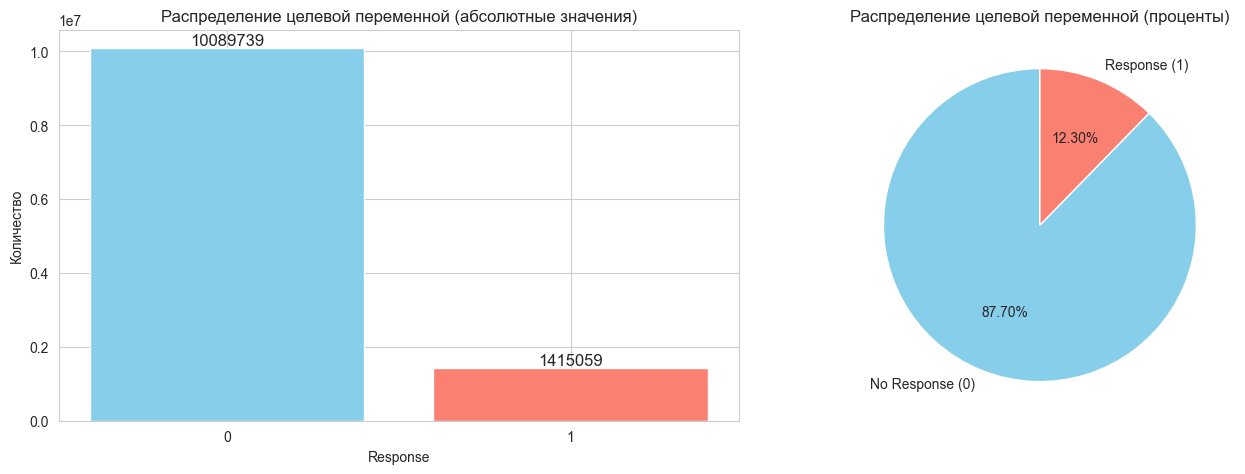

In [4]:
target_col = 'Response'
target_counts = train_data[target_col].value_counts()
target_props = train_data[target_col].value_counts(normalize=True)

print("Распределение целевой переменной:")
print(f"Класс 0: {target_counts[0]} ({target_props[0]*100:.2f}%)")
print(f"Класс 1: {target_counts[1]} ({target_props[1]*100:.2f}%)")
print(f"\nОбщее количество наблюдений: {len(train_data)}")
print(f"Дисбаланс классов: {target_counts[0] / target_counts[1]:.2f}:1")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(target_counts.index, target_counts.values, color=['skyblue', 'salmon'])
axes[0].set_xlabel('Response')
axes[0].set_ylabel('Количество')
axes[0].set_title('Распределение целевой переменной (абсолютные значения)')
axes[0].set_xticks([0, 1])
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v, str(v), ha='center', va='bottom', fontsize=12)

axes[1].pie(target_counts.values, labels=['No Response (0)', 'Response (1)'], 
            autopct='%1.2f%%', colors=['skyblue', 'salmon'], startangle=90)
axes[1].set_title('Распределение целевой переменной (проценты)')

plt.tight_layout()
plt.savefig(OTHER_DIR / 'target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.2. Типизация признаков и их распределения

Делим признаки на численные и категориальные. В данных 7 численных признаков (Age, Driving_License, Region_Code, Previously_Insured, Annual_Premium, Policy_Sales_Channel, Vintage) и 3 категориальных признака (Gender, Vehicle_Age, Vehicle_Damage). Возраст клиентов варьируется от 20 до 85 лет со средним значением 38.4 года.

In [5]:
numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist()

if 'id' in numeric_cols:
    numeric_cols.remove('id')
if target_col in numeric_cols:
    numeric_cols.remove(target_col)

print("Численные признаки:", numeric_cols)
print(f"\nКоличество численных признаков: {len(numeric_cols)}")
print("\nКатегориальные признаки:", categorical_cols)
print(f"Количество категориальных признаков: {len(categorical_cols)}")



Численные признаки: ['Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

Количество численных признаков: 7

Категориальные признаки: ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
Количество категориальных признаков: 3


In [6]:
print("Статистика по числовым признакам:")
print(train_data[numeric_cols].describe())

Статистика по числовым признакам:
                Age  Driving_License   Region_Code  Previously_Insured  \
count  1.150480e+07     1.150480e+07  1.150480e+07        1.150480e+07   
mean   3.838356e+01     9.980220e-01  2.641869e+01        4.629966e-01   
std    1.499346e+01     4.443120e-02  1.299159e+01        4.986289e-01   
min    2.000000e+01     0.000000e+00  0.000000e+00        0.000000e+00   
25%    2.400000e+01     1.000000e+00  1.500000e+01        0.000000e+00   
50%    3.600000e+01     1.000000e+00  2.800000e+01        0.000000e+00   
75%    4.900000e+01     1.000000e+00  3.500000e+01        1.000000e+00   
max    8.500000e+01     1.000000e+00  5.200000e+01        1.000000e+00   

       Annual_Premium  Policy_Sales_Channel       Vintage  
count    1.150480e+07          1.150480e+07  1.150480e+07  
mean     3.046137e+04          1.124254e+02  1.638977e+02  
std      1.645475e+04          5.403571e+01  7.997953e+01  
min      2.630000e+03          1.000000e+00  1.000000e+01  

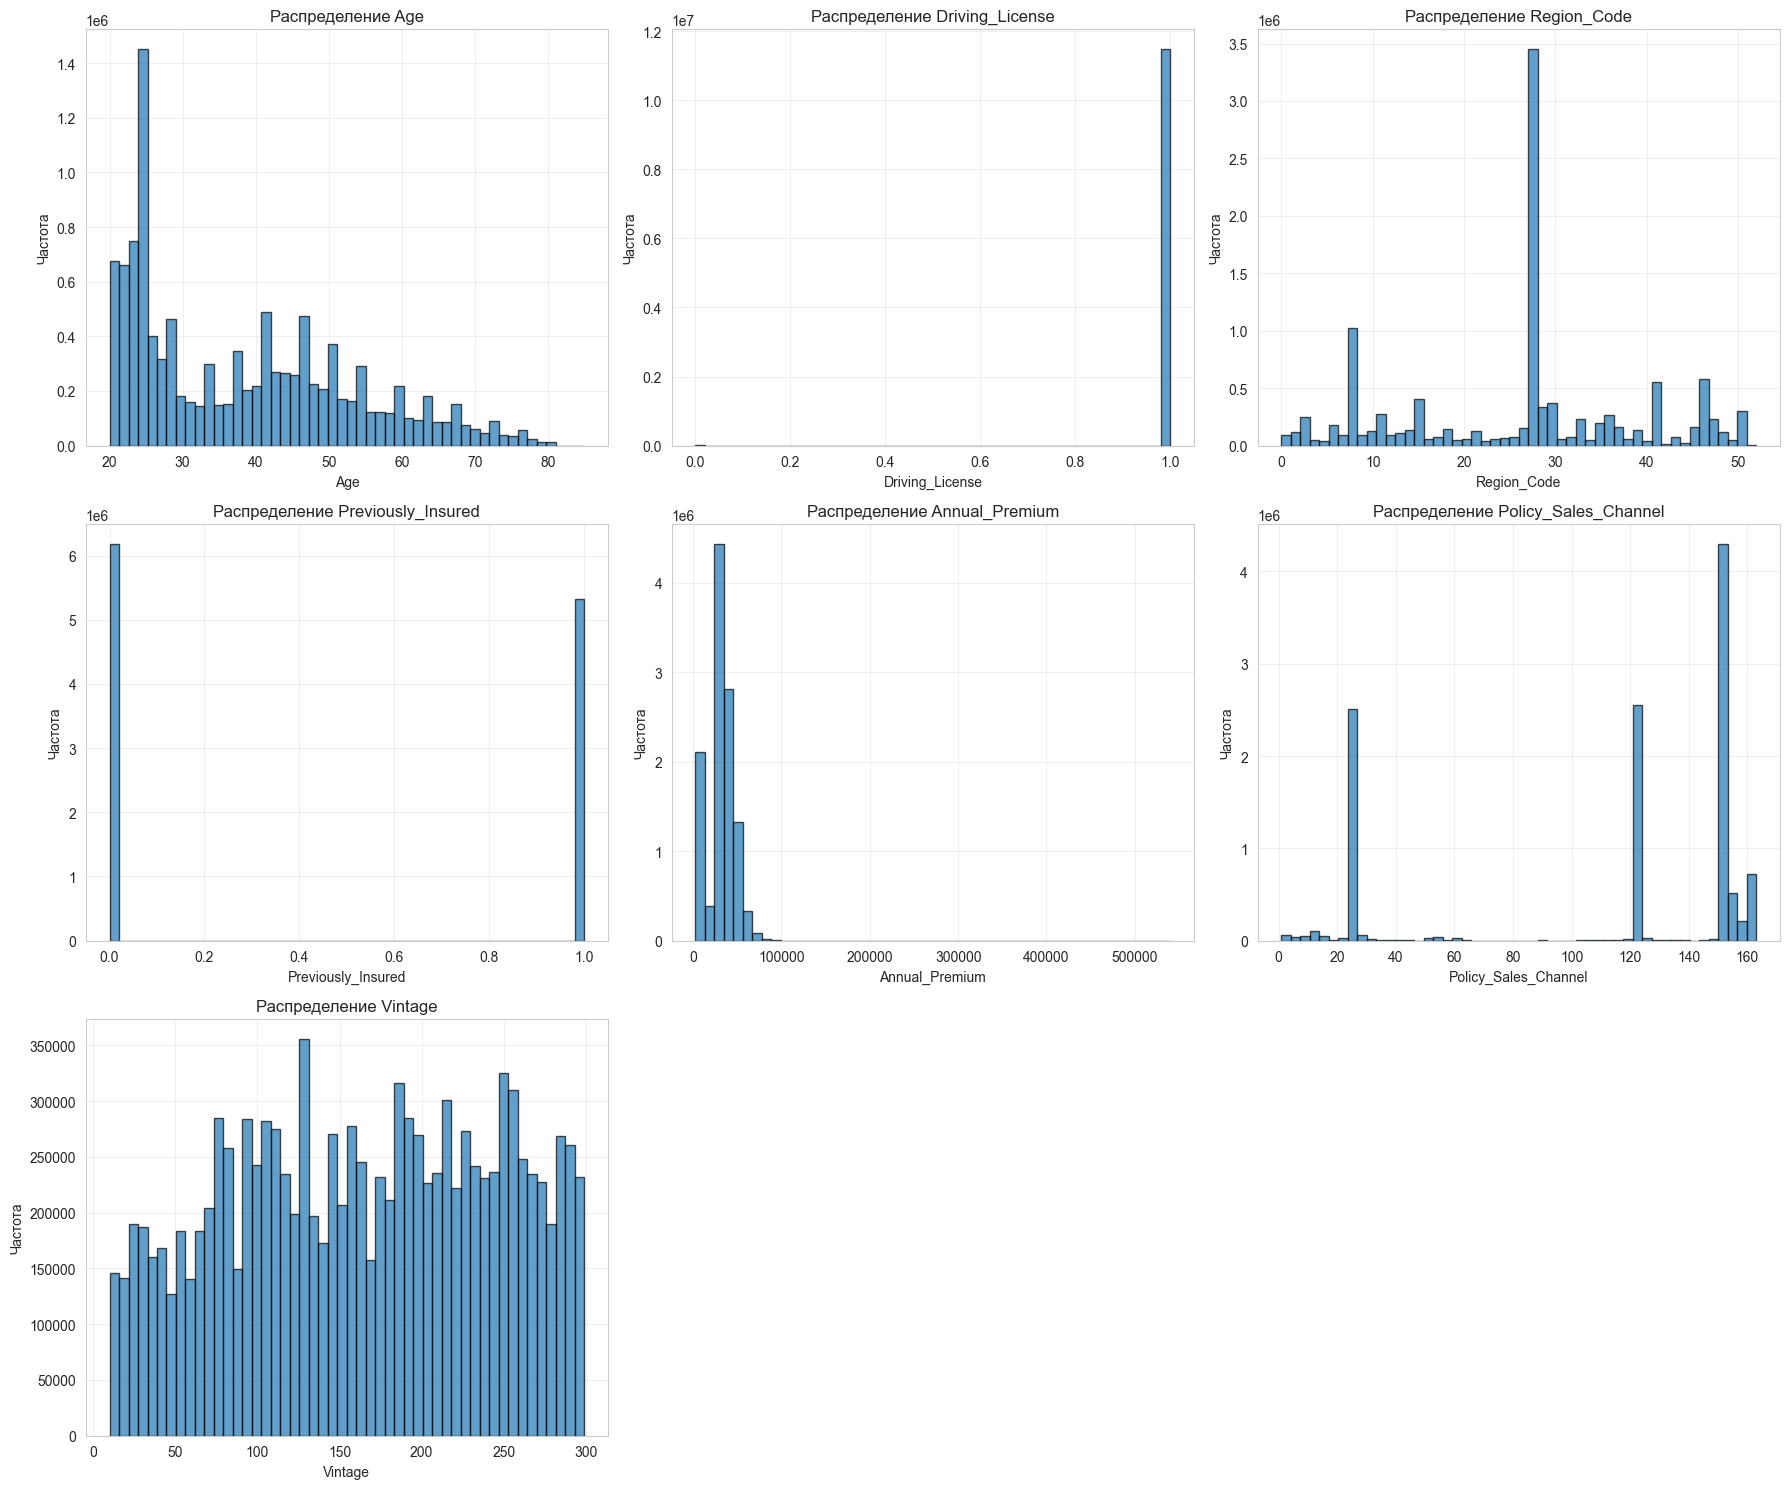

In [7]:
n_numeric = len(numeric_cols)
n_cols = 3
n_rows = (n_numeric + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].hist(train_data[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')
    axes[i].grid(True, alpha=0.3)

for i in range(n_numeric, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(OTHER_DIR / 'numeric_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.3. Выявление аномальных значений

Ищем выбросы в численных признаках. Это нужно чтобы понять качество данных и решить нужно ли их обрабатывать. Анализ показал наличие выбросов в признаке Annual_Premium: обнаружено 2,377,273 выброса (20.66% от всех данных). В признаке Driving_License найдено 22,757 выбросов (0.20%). Остальные численные признаки не содержат значимых выбросов. Выбросы в Annual_Premium могут влиять на качество модели и требуют специальной обработки.

Анализ выбросов (IQR метод):

Age:
Выбросов: 0 (0.00%)
Границы: [-13.50, 86.50]

Driving_License:
Выбросов: 22757 (0.20%)
Границы: [1.00, 1.00]

Region_Code:
Выбросов: 0 (0.00%)
Границы: [-15.00, 65.00]

Previously_Insured:
Выбросов: 0 (0.00%)
Границы: [-1.50, 2.50]

Annual_Premium:
Выбросов: 2377273 (20.66%)
Границы: [4016.00, 60712.00]

Policy_Sales_Channel:
Выбросов: 0 (0.00%)
Границы: [-155.50, 336.50]

Vintage:
Выбросов: 0 (0.00%)
Границы: [-100.50, 431.50]


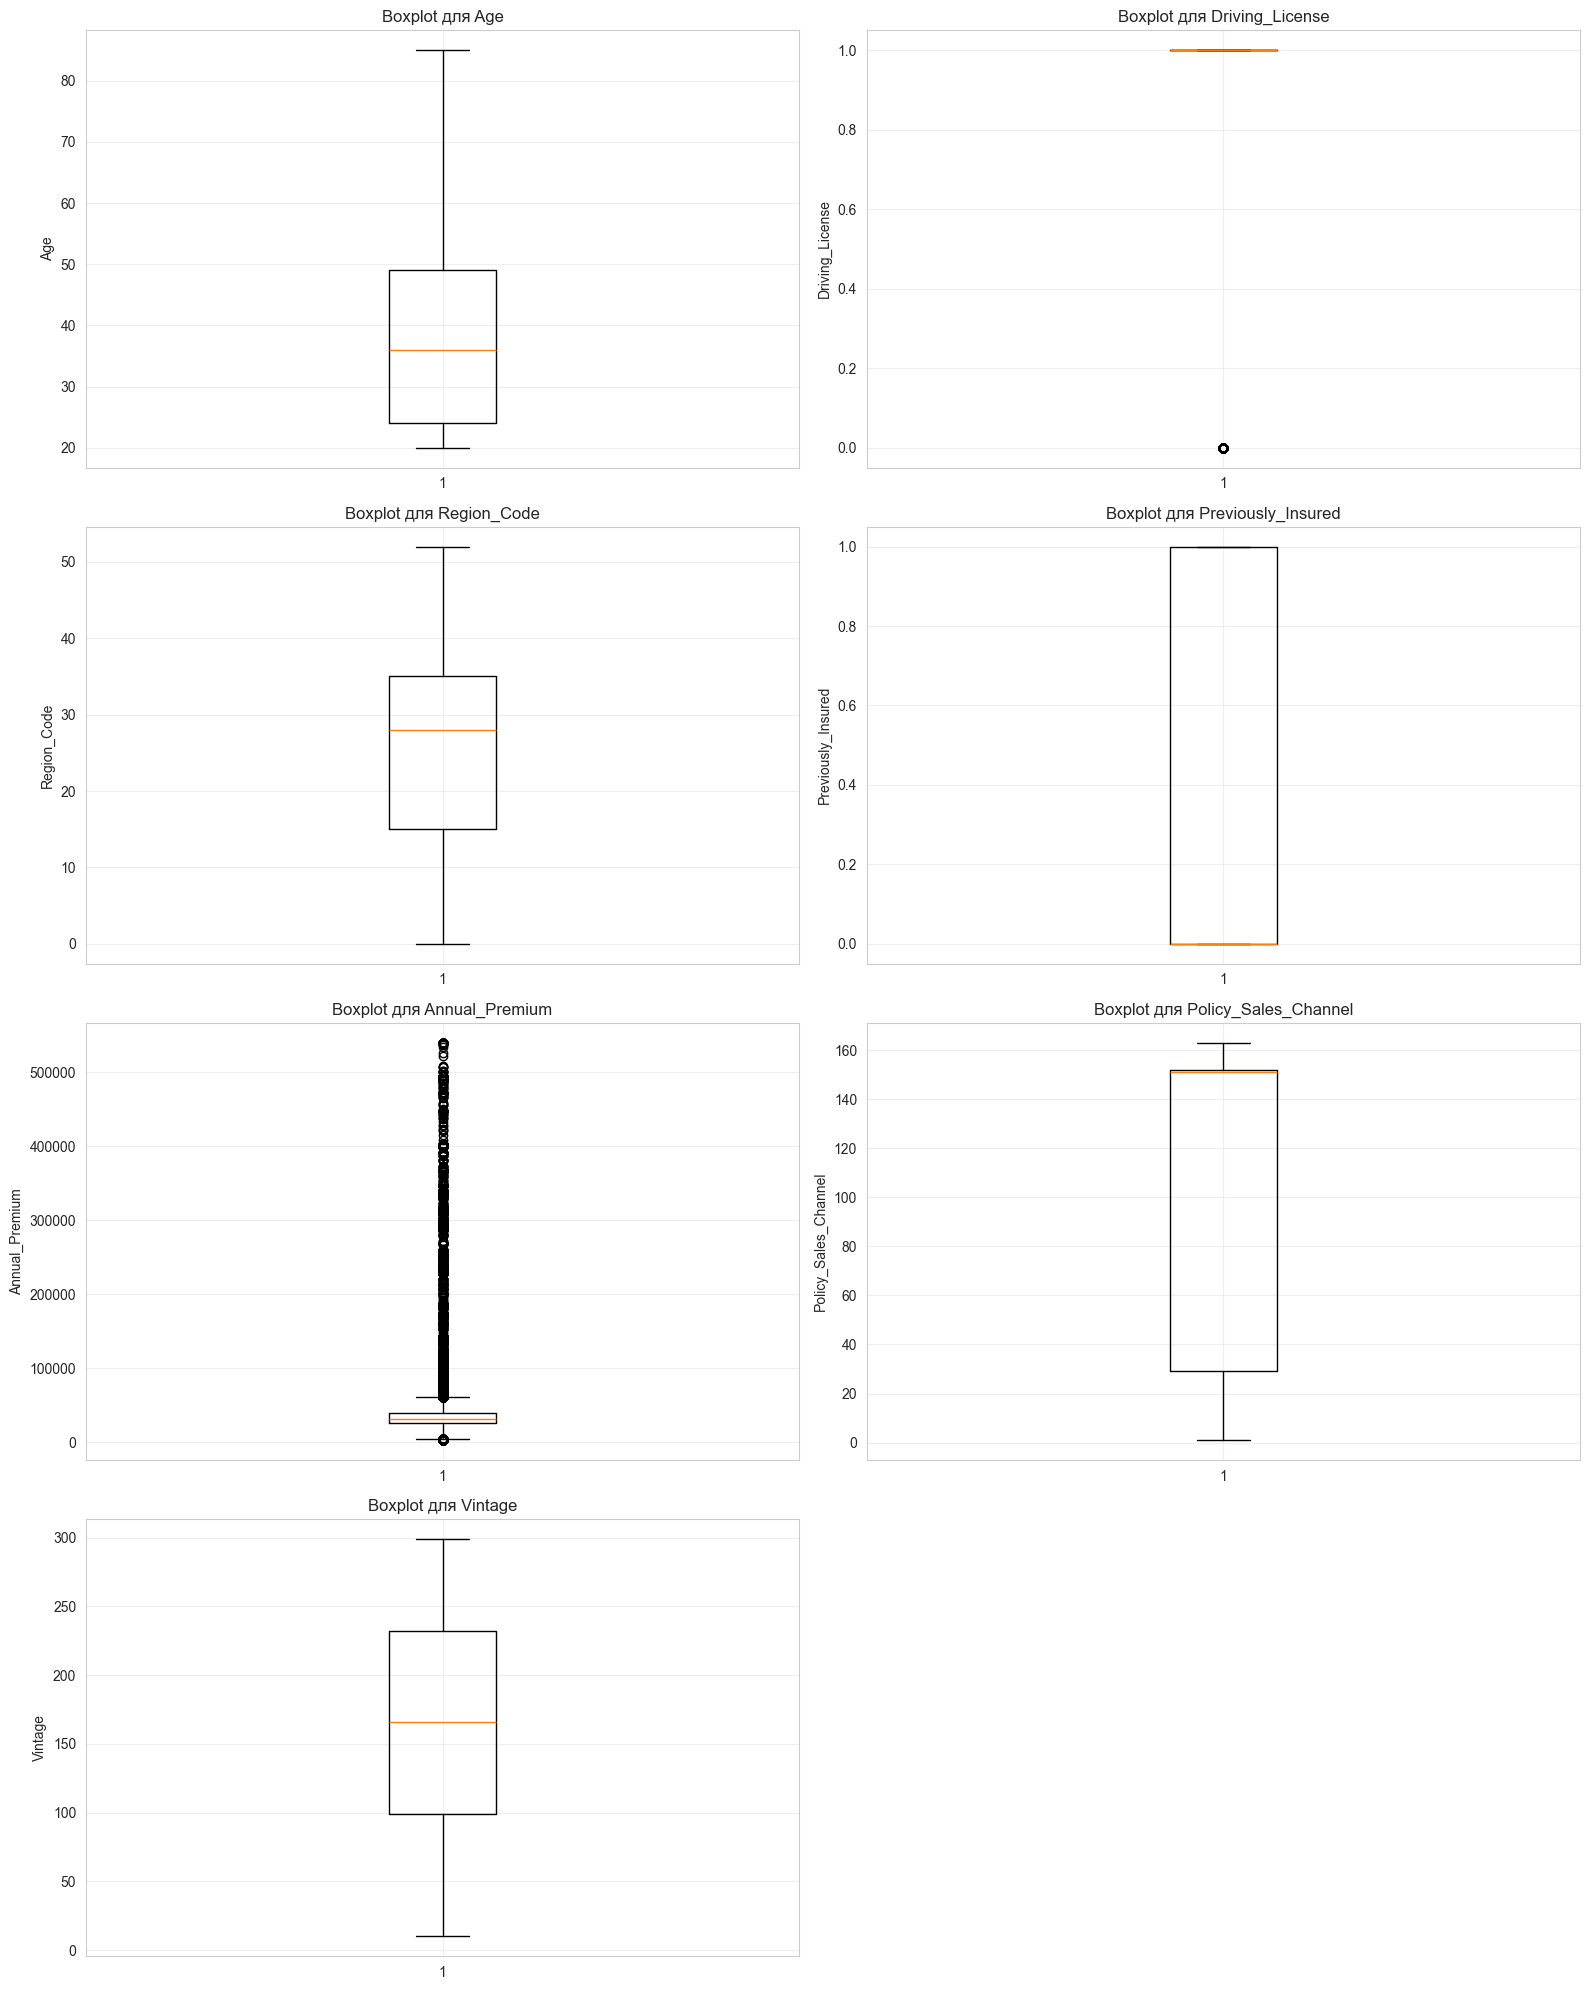

In [8]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

print("Анализ выбросов (IQR метод):")
print("="*60)
outliers_summary = {}

for col in numeric_cols:
    outliers, lower, upper = detect_outliers_iqr(train_data, col)
    n_outliers = len(outliers)
    pct_outliers = (n_outliers / len(train_data)) * 100
    outliers_summary[col] = {
        'count': n_outliers,
        'percentage': pct_outliers,
        'lower_bound': lower,
        'upper_bound': upper
    }
    print(f"\n{col}:")
    print(f"Выбросов: {n_outliers} ({pct_outliers:.2f}%)")
    print(f"Границы: [{lower:.2f}, {upper:.2f}]")

n_numeric = len(numeric_cols)
n_cols = 2
n_rows = (n_numeric + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].boxplot(train_data[col].dropna(), vert=True)
    axes[i].set_title(f'Boxplot для {col}')
    axes[i].set_ylabel(col)
    axes[i].grid(True, alpha=0.3)

for i in range(n_numeric, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(OTHER_DIR / 'outliers_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.4. Анализ пропущенных значений

Проверяем наличие пропущенных значений в данных. Анализ показал, что во всех признаках отсутствуют пропущенные значения.

In [9]:
missing_data = train_data.isnull().sum()
print(missing_data)


id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64


### 3.5. Определение важности признаков

Смотрим какие признаки важны. Для этого считаем корреляции с целевой переменной. Это помогает понять какие признаки дают больше всего информации. Наиболее сильная отрицательная корреляция наблюдается у признака Previously_Insured (-0.3459), что означает что клиенты которые уже застрахованы реже соглашаются на новое предложение. Признак Policy_Sales_Channel также показывает отрицательную корреляцию (-0.1527). Положительная корреляция наблюдается у признака Age (0.1221), что говорит о том что с возрастом вероятность положительного отклика немного увеличивается. Остальные признаки имеют слабую корреляцию с целевой переменной.

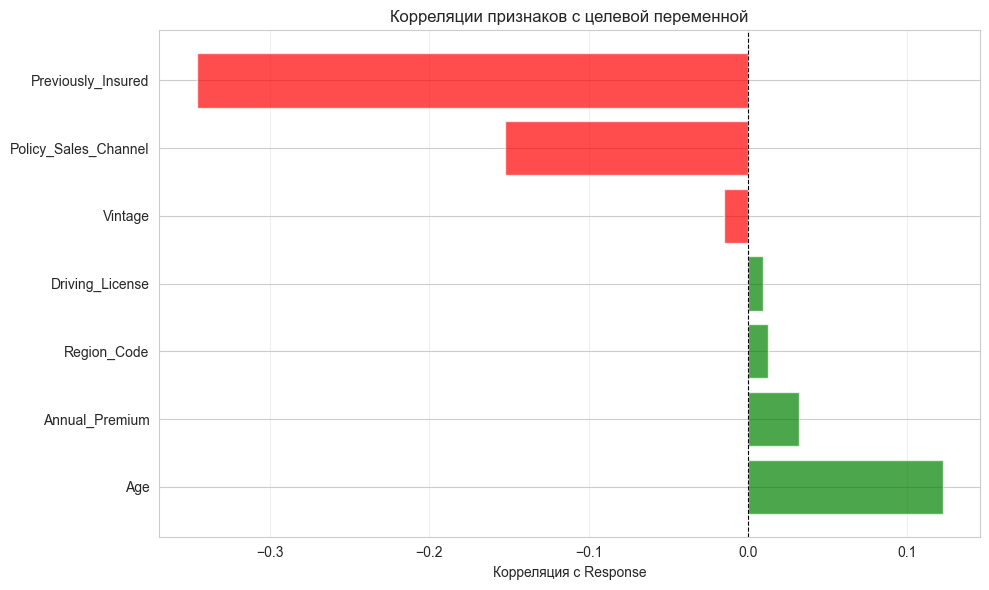

1. Previously_Insured: -0.3459
2. Policy_Sales_Channel: -0.1527
3. Age: 0.1221
4. Annual_Premium: 0.0323
5. Vintage: -0.0152
6. Region_Code: 0.0128
7. Driving_License: 0.0092


In [10]:
correlations = train_data[numeric_cols + [target_col]].corr()[target_col].sort_values(ascending=False)
target_correlations = correlations.drop(target_col)

plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'green' for x in target_correlations.values]
plt.barh(target_correlations.index, target_correlations.values, color=colors, alpha=0.7)
plt.xlabel('Корреляция с Response')
plt.title('Корреляции признаков с целевой переменной')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(OTHER_DIR / 'feature_importance_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

top_features = target_correlations.abs().sort_values(ascending=False).head(10)
for idx, (feature, corr) in enumerate(top_features.items(), 1):
    print(f"{idx}. {feature}: {target_correlations[feature]:.4f}")

### 3.6. Анализ возможных преобразований и генерации новых признаков

Смотрим на распределения признаков. Решаем нужно ли их преобразовывать и можно ли создать новые признаки. Признак Annual_Premium имеет скошенное распределение с большим разбросом значений (от 2,630 до 540,165), поэтому желательно логарифмическое преобразование. Возраст можно категоризировать на группы (молодые, средние, пожилые). Также можно создать признаки взаимодействия между важными признаками, например Age * Annual_Premium или комбинации категориальных признаков Vehicle_Age и Vehicle_Damage.

In [11]:
print("1. Age")
print(f"Min: {train_data['Age'].min()}")
print(f"Max: {train_data['Age'].max()}")
print(f"Mean: {train_data['Age'].mean():.2f}\n")

print("2. Annual_Premium")
print(f"Min: {train_data['Annual_Premium'].min()}")
print(f"Max: {train_data['Annual_Premium'].max()}")
print(f"Mean: {train_data['Annual_Premium'].mean():.2f}")

1. Age
Min: 20
Max: 85
Mean: 38.38

2. Annual_Premium
Min: 2630.0
Max: 540165.0
Mean: 30461.37


### 3.7. Анализ зависимостей между признаками

Изучаем корреляции между признаками и их связь с целевой переменной для понимания важности признаков. Анализ корреляций показывает что большинство признаков имеют слабую связь между собой, что хорошо для обучения. Наиболее важными для предсказания являются признаки Previously_Insured, Policy_Sales_Channel и Age, которые показывают наибольшую корреляцию с целевой переменной Response.

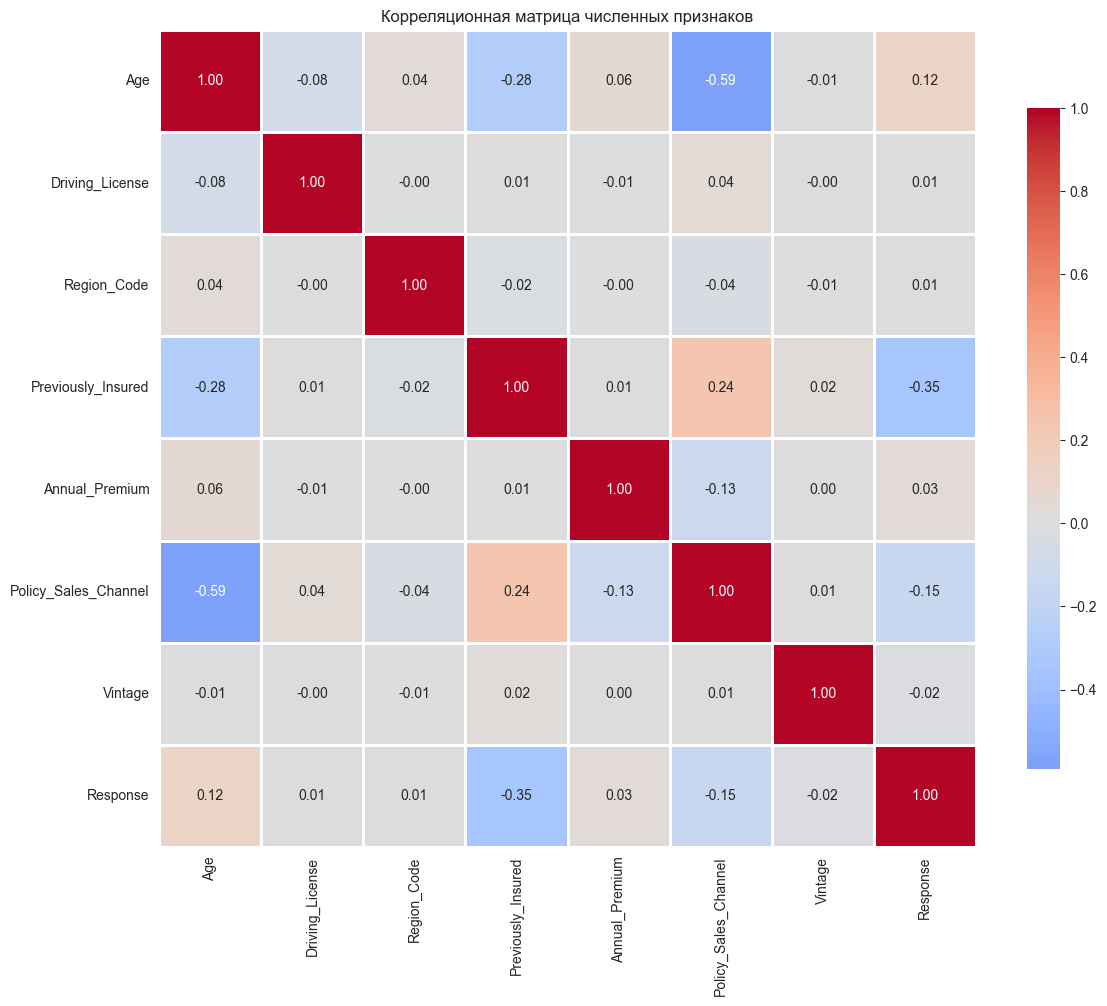


корреляции с целевой переменной:
Age                     0.122134
Annual_Premium          0.032261
Region_Code             0.012816
Driving_License         0.009197
Vintage                -0.015177
Policy_Sales_Channel   -0.152733
Previously_Insured     -0.345930
Name: Response, dtype: float64


In [12]:
correlation_matrix = train_data[numeric_cols + [target_col]].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Корреляционная матрица численных признаков')
plt.tight_layout()
plt.savefig(OTHER_DIR / 'correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

target_correlations = correlation_matrix[target_col].drop(target_col).sort_values(ascending=False)
print("\nкорреляции с целевой переменной:")
print("="*60)
print(target_correlations)

### 3.8. Основные выводы EDA

После анализа данных мы выяснили следующее:

1. **Дисбаланс классов**: Классы распределены неравномерно - класс 0 составляет 87.70% (10,089,739 наблюдений), класс 1 только 12.30% (1,415,059 наблюдений). Соотношение 7.13:1. Нужно учесть это при обучении моделей используя техники балансировки классов.

2. **Важные признаки**: Наиболее важными признаками являются Previously_Insured (корреляция -0.3459), Policy_Sales_Channel (-0.1527) и Age (0.1221). Эти признаки сильнее всего связаны с целевой переменной.

3. **Типы данных**: В данных 7 численных признаков и 3 категориальных.

4. **Распределения**: Признак Annual_Premium имеет скошенное распределение с большим разбросом значений, необходимо логарифмическое преобразование.

5. **Выбросы**: Найдены выбросы в Annual_Premium (20.66% данных) и Driving_License (0.20%). Выбросы в Annual_Premium требуют специальной обработки.

6. **Пропущенные значения**: Пропущенных значений в данных нет, все 11,504,798 наблюдений содержат полную информацию.

7. **Преобразования**: Желательно логарифмирование Annual_Premium, категоризация Age, создание признаков взаимодействия между важными признаками.

## 4. Подготовка данных для моделирования

Делим данные на train и validation со стратификацией, потому что классы несбалансированы и нам важно сохранить их доли. Берем 20 процентов под validation и фиксируем random_state=42 для воспроизводимости. Утечку закрываем тем, что id не используем как признак и не добавляем информацию, которая появляется после момента предсказания.

In [13]:
X = train_data.drop([target_col, 'id'], axis=1)
y = train_data[target_col]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")
print(f"\nРаспределение классов в train:")
print(y_train.value_counts(normalize=True))
print(f"\nРаспределение классов в validation:")
print(y_val.value_counts(normalize=True))

Размер обучающей выборки: (9203838, 10)
Размер валидационной выборки: (2300960, 10)

Распределение классов в train:
Response
0    0.877003
1    0.122997
Name: proportion, dtype: float64

Распределение классов в validation:
Response
0    0.877003
1    0.122997
Name: proportion, dtype: float64


## 5. LightAutoML Baseline

В этом разделе делаем базовое решение с помощью LightAutoML. Проводим два эксперимента с разными настройками чтобы выбрать лучший вариант.

### 5.1. Конфигурация 1: Базовая настройка

Сначала построим самый простой бейзлайн на LightAutoML без серьезной настройки, ограничиваем время обучения и учимся на выборке 500к строк, потому что полный датасет очень большой и так быстрее проверить идею. Для надежной оценки используем кросс в 5 фолдов и фиксируем random_state.

In [29]:
task = Task('binary', metric='auc')

roles = {
    'target': target_col,
    'drop': ['id']
}

train_lam = pd.concat([X_train, y_train], axis=1)
train_lam = train_lam.reset_index(drop=True)

sample_size = 500000
if len(train_lam) > sample_size:
    train_lam_sample = train_lam.sample(n=sample_size, random_state=RANDOM_STATE)
    print(f"Используется выборка из {sample_size} строк для обучения")
else:
    train_lam_sample = train_lam

print("Обучение LightAutoML конфигурация 1")
start_time = time.time()

automl1 = TabularAutoML(
    task=task,
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
    general_params={'use_algos': [['linear_l2', 'lgb', 'lgb_tuned', 'cb']]}
)

oof_pred1 = automl1.fit_predict(train_lam_sample, roles=roles, verbose=1)

train_time1 = time.time() - start_time
print(f"Обучение завершено за {train_time1:.2f} секунд")

val_pred1 = automl1.predict(X_val.reset_index(drop=True))
val_pred1_proba = val_pred1.data[:, 0] if val_pred1.data.ndim > 1 else val_pred1.data

score1 = roc_auc_score(y_val.reset_index(drop=True), val_pred1_proba)
print(f"ROC-AUC конфигурация 1: {score1:.6f}")

joblib.dump(automl1, MODELS_DIR / 'lama_config1.pkl')
print(f"Модель сохранена: {MODELS_DIR / 'lama_config1.pkl'}")

Используется выборка из 500000 строк для обучения
Обучение LightAutoML конфигурация 1
[21:20:16] Stdout logging level is INFO.
[21:20:16] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[21:20:16] Task: binary

[21:20:16] Start automl preset with listed constraints:
[21:20:16] - time: 1800.00 seconds
[21:20:16] - CPU: 16 cores
[21:20:16] - memory: 16 GB

[21:20:16] Train data shape: (500000, 11)

[21:20:36] Layer 1 train process start. Time left 1779.56 secs
[21:20:44] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[21:21:04] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8737296264083111
[21:21:04] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[21:21:04] Time left 1752.18 secs

[21:21:06] Selector_LightGBM fitting and predicting completed
[21:21:14] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[21:21:24] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8686815680853346
[21:21:24] Lvl_0_Pipe_1_Mod_0_Light

Optimization Progress: 100%|██████████| 101/101 [03:56<00:00,  2.34s/it, best_trial=100, best_value=0.871]

[21:25:21] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[21:25:21] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[21:25:34] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8696492846291531
[21:25:34] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[21:25:34] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[21:26:24] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.8685317708587297
[21:26:24] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[21:26:24] Time left 1432.17 secs

[21:26:24] Layer 1 training completed.

[21:26:24] Blending: optimization starts with equal weights. Score = 0.8739455
[21:26:26] Blending: iteration 0: score = 0.8765821, weights = [0.6704342  0.14913028 0.18043557 0.        ]
[21:26:28] Blending: iteration 1: score = 0.8766603, weights = [0.6065783  0.15806907 0.23535265 0.        ]
[21:26:30] Blending: iteration 2: score = 0.8766666, weights = [0.6067139  0.14182718 0.25145894 0.        ]
[21:26:32] Blending: iteration 3: score = 0.8766715, weights = [0.6088653  0.12752432 0.26361036 0.        ]
[21:26:34] Blending: iteratio

### 5.2. Конфигурация 2: Расширенная настройка

Во второй конфигурации просим LightAutoML попробовать конкретные модели, если ограничить выбор алгоритмов и увеличить время обучения качество может вырасти. Это сравнение помогает понять, есть ли смысл усложнять настройку.

In [ ]:
print("Обучение LightAutoML конфигурация 2")
start_time = time.time()

automl2 = TabularAutoML(
    task=task,
    timeout=TIMEOUT * 2,
    cpu_limit=N_THREADS,
    reader_params={
        'n_jobs': N_THREADS, 
        'cv': N_FOLDS, 
        'random_state': RANDOM_STATE
    },
    general_params={
        'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]
    },
    tuning_params={
        'max_tuning_iter': 250,
        'max_tuning_time': 800,
        'fit_on_holdout': True
    },
    selection_params={
        'mode': 1,
        'importance_type': 'gain',
        'fit_on_holdout': True
    }
)
oof_pred2 = automl2.fit_predict(train_lam_sample, roles=roles, verbose=1)

train_time2 = time.time() - start_time
print(f"Обучение завершено за {train_time2:.2f} секунд")

val_pred2 = automl2.predict(X_val.reset_index(drop=True))
val_pred2_proba = val_pred2.data[:, 0] if val_pred2.data.ndim > 1 else val_pred2.data

score2 = roc_auc_score(y_val.reset_index(drop=True), val_pred2_proba)
print(f"ROC-AUC конфигурация 2: {score2:.6f}")

joblib.dump(automl2, MODELS_DIR / 'lama_config2.pkl')
print(f"Модель сохранена: {MODELS_DIR / 'lama_config2.pkl'}")

Обучение LightAutoML конфигурация 2
[11:06:04] Stdout logging level is INFO.
[11:06:04] Task: binary

[11:06:04] Start automl preset with listed constraints:
[11:06:04] - time: 3600.00 seconds
[11:06:04] - CPU: 16 cores
[11:06:04] - memory: 16 GB

[11:06:04] Train data shape: (500000, 11)

[11:06:11] Layer 1 train process start. Time left 3593.02 secs
[11:06:18] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[11:06:37] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8737668079133237
[11:06:37] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[11:06:37] Time left 3566.50 secs

[11:06:39] Selector_LightGBM fitting and predicting completed
[11:06:47] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[11:06:59] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8686815680853346
[11:06:59] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[11:06:59] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 800.00 secs


Optimization Progress: 100%|██████████| 250/250 [11:53<00:00,  2.86s/it, best_trial=209, best_value=0.871]

[11:18:52] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[11:18:52] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[11:19:20] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8697426091068572
[11:19:20] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[11:19:20] Time left 2803.37 secs

[11:19:20] Layer 1 training completed.

[11:19:20] Blending: optimization starts with equal weights. Score = 0.8750297
[11:19:22] Blending: iteration 0: score = 0.8766706, weights = [0.60501844 0.17357859 0.22140294]
[11:19:23] Blending: iteration 1: score = 0.8766806, weights = [0.6064344  0.15261787 0.24094774]
[11:19:25] Blending: iteration 2: score = 0.8766876, weights = [0.60735625 0.1346268  0.25801688]
[11:19:26] Blending: iteration 3: score = 0.8766911, weights = [0.6073863  0.12298153 0.2696322 ]
[11:19:28] Blending: iteration 4: score = 0.8766941, weights = [0.6080522  0.11170325 0.28024453]
[11:19:28] Blending: best score = 0.8766941, best weights = [0.6080522  0.11170325 0.28024453]
[11:19:28] Automl preset training completed in 804.32 seconds

[11:19:28] Model description:


### 5.3. Сравнение конфигураций LightAutoML

Сравниваем обе конфигурации по ROC AUC, потому что это метрика соревнования. Параллельно смотрим на время обучения, чтобы понимать, насколько дорого обходится улучшение. Из результатов видно что усложнив конфигурацию принципиальных различий в результатах нет, только значительно увеличилось время обучения, поэтому выберем простой вариант.

           Конфигурация   ROC-AUC  Время обучения (сек)
0  LightAutoML Config 1  0.875943            365.300634
1  LightAutoML Config 2  0.875985            804.338054

Лучшая конфигурация: Config 2
Лучший ROC-AUC: 0.875985


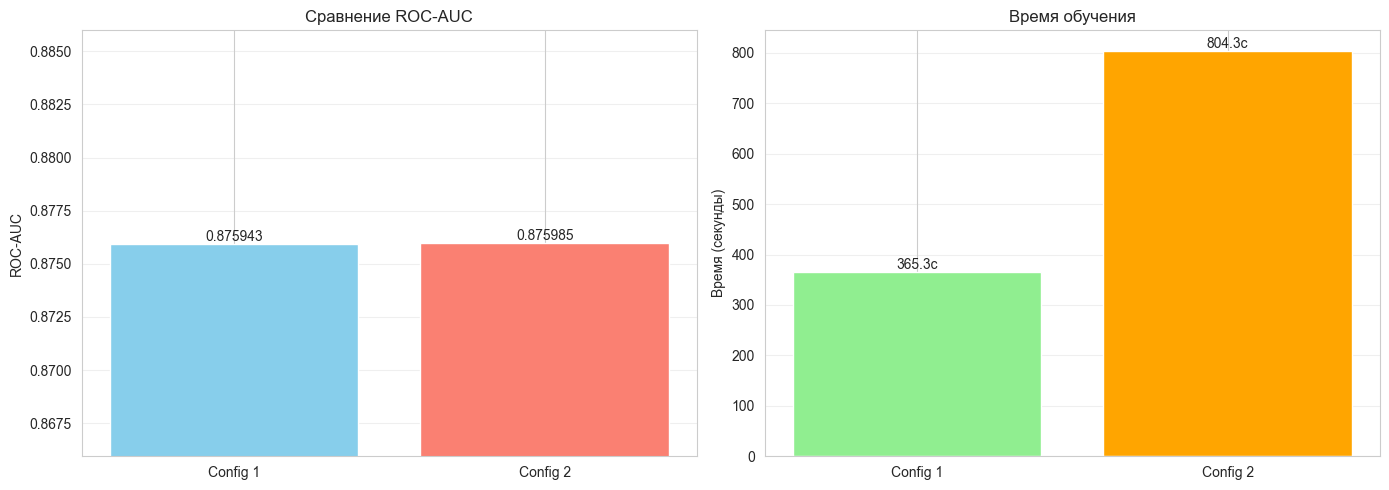

In [ ]:
results_comparison = pd.DataFrame({
    'Конфигурация': ['LightAutoML Config 1', 'LightAutoML Config 2'],
    'ROC-AUC': [score1, score2],
    'Время обучения (сек)': [train_time1, train_time2]
})

print(results_comparison)

best_automl = automl1 if score1 >= score2 else automl2
best_score = max(score1, score2)
best_config = 'Config 1' if score1 >= score2 else 'Config 2'

print(f"\nЛучшая конфигурация: {best_config}")
print(f"Лучший ROC-AUC: {best_score:.6f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(['Config 1', 'Config 2'], [score1, score2], color=['skyblue', 'salmon'])
axes[0].set_ylabel('ROC-AUC')
axes[0].set_title('Сравнение ROC-AUC')
axes[0].set_ylim([min(score1, score2) - 0.01, max(score1, score2) + 0.01])
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate([score1, score2]):
    axes[0].text(i, v, f'{v:.6f}', ha='center', va='bottom')

axes[1].bar(['Config 1', 'Config 2'], [train_time1, train_time2], color=['lightgreen', 'orange'])
axes[1].set_ylabel('Время (секунды)')
axes[1].set_title('Время обучения')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate([train_time1, train_time2]):
    axes[1].text(i, v, f'{v:.1f}с', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(OTHER_DIR / 'baseline_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

baseline_metrics = {
    'config1_auc': float(score1),
    'config2_auc': float(score2),
    'best_config': best_config,
    'best_auc': float(best_score)
}
import json
with open(PARAMS_DIR / 'baseline_metrics.json', 'w') as f:
    json.dump(baseline_metrics, f, indent=2)

### 5.4. Обучение лучшей модели на всех данных

После выбора лучшей конфигурации обучаем ее на всем train, потому что для финального решения важно использовать максимум данных. Для полного датасета увеличиваем лимит по времени, иначе обучение может не успеть нормально завершиться.

In [ ]:
print("Обучение лучшей модели LightAutoML на всех данных")

train_data_full = pd.read_csv(DATA_DIR / 'train.csv')
train_lam_full = train_data_full.drop(['id'], axis=1, errors='ignore')
train_lam_full = train_lam_full.reset_index(drop=True)

print(f"Размер полного датасета: {len(train_lam_full)} строк")

print("Обучение LightAutoML на полном датасете")
start_time = time.time()

# без cb, не работает на всем датасете(
automl_final = TabularAutoML(
    task=task,
    timeout=TIMEOUT*5,
    cpu_limit=N_THREADS,
    reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
    general_params={'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]}
)

oof_pred_final = automl_final.fit_predict(train_lam_full, roles=roles, verbose=1)

train_time_final = time.time() - start_time
print(f"Обучение завершено за {train_time_final:.2f} секунд")

joblib.dump(automl_final, MODELS_DIR / 'lama_final.pkl')
print(f"Финальная модель сохранена: {MODELS_DIR / 'lama_final.pkl'}")

Обучение лучшей модели LightAutoML на всех данных
Размер полного датасета: 11504798 строк
Обучение LightAutoML на полном датасете
[12:19:19] Stdout logging level is INFO.
[12:19:19] Task: binary

[12:19:19] Start automl preset with listed constraints:
[12:19:19] - time: 9000.00 seconds
[12:19:19] - CPU: 16 cores
[12:19:19] - memory: 16 GB

[12:19:19] Train data shape: (11504798, 11)

[12:19:31] Layer 1 train process start. Time left 8988.67 secs
[12:22:20] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[12:26:51] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8747224795998259
[12:26:51] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[12:26:51] Time left 8548.21 secs

[12:30:13] Selector_LightGBM fitting and predicting completed
[12:33:22] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[12:38:54] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8741067416178282
[12:38:54] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[12:38:54] Start hyperparam

Optimization Progress:   2%|▏         | 2/101 [05:33<4:35:30, 166.98s/it, best_trial=1, best_value=0.875]

[12:44:28] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[12:44:28] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[12:59:20] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8744681275340629
[12:59:20] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[12:59:20] Time left 6599.45 secs

[12:59:20] Layer 1 training completed.

[12:59:23] Blending: optimization starts with equal weights. Score = 0.8786178
[13:00:22] Blending: iteration 0: score = 0.8794030, weights = [0.5081756  0.19243884 0.29938555]
[13:01:22] Blending: iteration 1: score = 0.8794454, weights = [0.51290786 0.14103885 0.34605327]
[13:02:21] Blending: iteration 2: score = 0.8794808, weights = [0.5169587  0.09268539 0.39035589]
[13:03:21] Blending: iteration 3: score = 0.8795022, weights = [0.5195201  0.06025551 0.42022434]
[13:04:21] Blending: iteration 4: score = 0.8795368, weights = [0.52373666 0.         0.47626334]
[13:04:21] Blending: best score = 0.8795368, best weights = [0.52373666 0.         0.47626334]
[13:04:21] Automl preset training completed in 2701.73 seconds

[13:04:21] Model description:

### 5.5. Генерация submission для baseline

Делаем предсказания на test и сохраняем их в CSV. Используем финальную модель, обученную на всех данных, чтобы получить максимально возможное качество для отправки.
В результате на закрытых тестах бейзлайн модель показала хороший результат `0.87945`, лучше чем у примерно половины участников 

In [ ]:
test_data_full = pd.read_csv(DATA_DIR / 'test.csv')
print(f"Размер тестовой выборки: {len(test_data_full)}")

test_pred = automl_final.predict(test_data_full)
test_pred_proba = test_pred.data[:, 0] if test_pred.data.ndim > 1 else test_pred.data

submission_baseline = pd.DataFrame({
    'id': test_data_full['id'].values,
    'Response': test_pred_proba
})

submission_file_baseline = SUBMIT_DIR / 'baseline_submission.csv'
submission_baseline.to_csv(submission_file_baseline, index=False)

print(f"Submission создан: {submission_file_baseline}")
print(f"Размер: {submission_baseline.shape}")
print(f"Диапазон предсказаний: [{test_pred_proba.min():.6f}, {test_pred_proba.max():.6f}]")
print(f"Среднее предсказание: {test_pred_proba.mean():.6f}")

Размер тестовой выборки: 7669866
Submission создан: src\baseline_submission.csv
Размер: (7669866, 2)
Диапазон предсказаний: [0.000010, 0.929261]
Среднее предсказание: 0.122994


## 6. Собственное решение без LightAutoML

В этом разделе показываем собственные решения без LightAutoML. Делаем несколько экспериментов от простых к сложным чтобы найти лучшее решение. Артефакты блокнота сохраняются в `src/`.

### 6.1. Pipeline версии 1: Базовый подход

Начинаем с простого пайплайна на RandomForest, добавляем пару простых признаков из EDA, логарифмируем Annual_Premium из-за сильной асимметрии, делаем группы по возрасту и добавляем взаимодействие возраста с Premium, потому что вместе эти признаки часто несут больше смысла, чем по отдельности. Категории кодируем числами, пропуски заполняем медианой, чтобы не ломать обучение. Параметры RandomForest берем умеренные и ограничиваем глубину, чтобы модель меньше переобучалась и работала стабильно.

In [30]:
def create_features_v1(df):
    df = df.copy()
    
    # Логарифмирование
    if 'Annual_Premium' in df.columns:
        df['Annual_Premium_log'] = np.log1p(df['Annual_Premium'])
    
    # Категоризация
    if 'Age' in df.columns:
        df['Age_group'] = pd.cut(df['Age'], 
                                bins=[0, 25, 35, 45, 55, 100],
                                labels=['18-25', '26-35', '36-45', '46-55', '55+'])
        df['Age_group'] = df['Age_group'].astype(str)
    
    # Взаимодействие Age и Annual_Premium
    if 'Age' in df.columns and 'Annual_Premium' in df.columns:
        df['Age_Premium_interaction'] = df['Age'] * df['Annual_Premium'] / 1000
    
    return df

def preprocess_data_v1(X_train, X_val):
    X_train_proc = create_features_v1(X_train)
    X_val_proc = create_features_v1(X_val)
    
    categorical_cols = X_train_proc.select_dtypes(include=['object']).columns.tolist()
    
    # Label Encoding для категориальных
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X_train_proc[col] = le.fit_transform(X_train_proc[col].astype(str))
        X_val_proc[col] = le.transform(X_val_proc[col].astype(str))
        label_encoders[col] = le
    
    # Заполнение пропусков
    numeric_cols = X_train_proc.select_dtypes(include=[np.number]).columns.tolist()
    for col in numeric_cols:
        median_val = X_train_proc[col].median()
        X_train_proc[col].fillna(median_val, inplace=True)
        X_val_proc[col].fillna(median_val, inplace=True)
    
    return X_train_proc, X_val_proc, label_encoders

print("Предобработка данных Pipeline v1")
X_train_proc_v1, X_val_proc_v1, encoders_v1 = preprocess_data_v1(X_train, X_val)

sample_size = 2000000
if len(X_train_proc_v1) > sample_size:
    sample_idx = np.random.choice(len(X_train_proc_v1), sample_size, replace=False)
    X_train_sample_v1 = X_train_proc_v1.iloc[sample_idx]
    y_train_sample_v1 = y_train.iloc[sample_idx]
    print(f"Используется выборка из {sample_size} строк")
else:
    X_train_sample_v1 = X_train_proc_v1
    y_train_sample_v1 = y_train

print("Обучение Pipeline v1")
start_time = time.time()

pipeline_v1 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=150,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=RANDOM_STATE,
        n_jobs=N_THREADS,
        verbose=0
    ))
])

pipeline_v1.fit(X_train_sample_v1, y_train_sample_v1)

train_time_v1 = time.time() - start_time
print(f"Обучение завершено за {train_time_v1:.2f} секунд")

val_pred_proba_v1 = pipeline_v1.predict_proba(X_val_proc_v1)[:, 1]
score_v1 = roc_auc_score(y_val, val_pred_proba_v1)

print(f"ROC-AUC Pipeline v1: {score_v1:.6f}")

joblib.dump(pipeline_v1, MODELS_DIR / 'pipeline_v1.pkl')
print(f"Модель сохранена: {MODELS_DIR / 'pipeline_v1.pkl'}")

Предобработка данных Pipeline v1
Используется выборка из 2000000 строк
Обучение Pipeline v1
Обучение завершено за 31.71 секунд
ROC-AUC Pipeline v1: 0.860628
Модель сохранена: src\models\pipeline_v1.pkl


Результат `0.86063` чуть хуже чем `0.87945` у LightAutoML

### 6.2. Старая версия
#### Pipeline версии 2: LightGBM подход

Во второй попытке переходим на бустинг, потому что для табличных данных он часто дает лучшее качество, чем RandomForest. Перед обучением делаем более аккуратную подготовку данных: убираем дубликаты, пробуем мягко отфильтровать явные аномалии и добавляем несколько дополнительных признаков, которые подсказал EDA. Дальше обучаем LightGBM и учитываем дисбаланс классов.

In [ ]:
print("Загрузка модели Pipeline v2")

import lightgbm as lgb

model_path = MODELS_DIR / 'model_v2_lgb.pkl'

def remove_duplicates(X, y=None):
    initial_size = len(X)
    if y is not None:
        X_with_target = X.copy()
        X_with_target['_target'] = y.values
        X_with_target = X_with_target.drop_duplicates()
        y_cleaned = pd.Series(X_with_target['_target'].values, index=X_with_target.index)
        X_cleaned = X_with_target.drop('_target', axis=1)
        duplicates_removed = initial_size - len(X_cleaned)
        if duplicates_removed > 0:
            print(f"Удалено дубликатов: {duplicates_removed:,} ({duplicates_removed/initial_size*100:.2f}%)")
        return X_cleaned, y_cleaned
    else:
        X_cleaned = X.drop_duplicates()
        duplicates_removed = initial_size - len(X_cleaned)
        if duplicates_removed > 0:
            print(f"Удалено дубликатов: {duplicates_removed:,} ({duplicates_removed/initial_size*100:.2f}%)")
        return X_cleaned

def detect_and_remove_anomalies(X, y=None, z_threshold=4.0, iqr_factor=2.5):
    initial_size = len(X)
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    anomaly_indices = set()
    
    for col in numeric_cols:
        col_data = X[col].dropna()
        if len(col_data) == 0:
            continue
        z_scores = np.abs(stats.zscore(col_data))
        z_outliers = col_data.index[z_scores > z_threshold].tolist()
        Q1 = col_data.quantile(0.25)
        Q3 = col_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_factor * IQR
        upper_bound = Q3 + iqr_factor * IQR
        iqr_outliers = col_data.index[(col_data < lower_bound) | (col_data > upper_bound)].tolist()
        outliers = set(z_outliers) & set(iqr_outliers)
        anomaly_indices.update(outliers)
    
    if len(anomaly_indices) > 0:
        anomaly_pct = len(anomaly_indices) / initial_size * 100
        if anomaly_pct < 5.0:
            X_cleaned = X.drop(index=anomaly_indices)
            if y is not None:
                y_cleaned = y.drop(index=anomaly_indices)
                print(f"Удалено аномалий: {len(anomaly_indices):,} ({anomaly_pct:.2f}%)")
                return X_cleaned, y_cleaned
            else:
                print(f"Удалено аномалий: {len(anomaly_indices):,} ({anomaly_pct:.2f}%)")
                return X_cleaned
    
    if y is not None:
        return X, y
    else:
        return X

def create_features_improved(df):
    df = df.copy()
    if 'Annual_Premium' in df.columns:
        df['Annual_Premium_log'] = np.log1p(df['Annual_Premium'])
        df['Annual_Premium_sqrt'] = np.sqrt(df['Annual_Premium'])
    if 'Age' in df.columns:
        df['Age_group'] = pd.cut(df['Age'], bins=[0, 25, 35, 45, 55, 100], labels=['18-25', '26-35', '36-45', '46-55', '55+'])
        df['Age_group'] = df['Age_group'].astype(str)
        df['Age_squared'] = df['Age'] ** 2
        df['Age_cubed'] = df['Age'] ** 3
    if 'Age' in df.columns and 'Annual_Premium' in df.columns:
        df['Age_Premium_interaction'] = df['Age'] * df['Annual_Premium'] / 1000
        df['Age_Premium_ratio'] = df['Annual_Premium'] / (df['Age'] + 1)
    if 'Vehicle_Age' in df.columns and 'Vehicle_Damage' in df.columns:
        df['Vehicle_combination'] = df['Vehicle_Age'].astype(str) + '_' + df['Vehicle_Damage'].astype(str)
    if 'Previously_Insured' in df.columns and 'Vehicle_Damage' in df.columns:
        df['Insured_Damage'] = df['Previously_Insured'].astype(str) + '_' + df['Vehicle_Damage'].astype(str)
    if 'Region_Code' in df.columns and 'Policy_Sales_Channel' in df.columns:
        df['Region_Channel'] = df['Region_Code'].astype(str) + '_' + df['Policy_Sales_Channel'].astype(str)
    return df

def preprocess_data_improved(X_train, X_val):
    X_train_proc = create_features_improved(X_train)
    X_val_proc = create_features_improved(X_val)
    
    categorical_cols = X_train_proc.select_dtypes(include=['object']).columns.tolist()
    numeric_cols = X_train_proc.select_dtypes(include=[np.number]).columns.tolist()
    
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X_train_proc[col] = le.fit_transform(X_train_proc[col].astype(str))
        X_val_proc[col] = X_val_proc[col].astype(str)
        known_classes = set(le.classes_)
        X_val_proc.loc[~X_val_proc[col].isin(known_classes), col] = le.classes_[0]
        X_val_proc[col] = le.transform(X_val_proc[col])
        label_encoders[col] = le
    
    for col in numeric_cols:
        median_val = X_train_proc[col].median()
        if pd.isna(median_val):
            median_val = 0.0
        X_train_proc[col] = X_train_proc[col].fillna(median_val)
        X_val_proc[col] = X_val_proc[col].fillna(median_val)
    
    return X_train_proc, X_val_proc

print("Предобработка данных")
X_train_clean, y_train_clean = remove_duplicates(X_train.copy(), y_train.copy())
X_train_clean, y_train_clean = detect_and_remove_anomalies(X_train_clean, y_train_clean)

X_train_proc, X_val_proc = preprocess_data_improved(X_train_clean, X_val.copy())

if model_path.exists():
    print("Загрузка модели")
    model_improved = joblib.load(model_path)
    
    val_pred_proba_improved = model_improved.predict(X_val_proc, num_iteration=model_improved.best_iteration)
    score_improved = roc_auc_score(y_val, val_pred_proba_improved)
    
    print(f"ROC-AUC на валидации (Улучшенная модель): {score_improved:.6f}")
else:
    print("Обучение модели")
    
    sample_size = 2000000
    if len(X_train_proc) > sample_size:
        sample_idx = np.random.choice(len(X_train_proc), sample_size, replace=False)
        X_train_sample = X_train_proc.iloc[sample_idx]
        y_train_sample = y_train_clean.iloc[sample_idx]
        print(f"Используется выборка из {sample_size} строк для обучения")
    else:
        X_train_sample = X_train_proc
        y_train_sample = y_train_clean
    
    train_data = lgb.Dataset(X_train_sample, label=y_train_sample)
    val_data = lgb.Dataset(X_val_proc, label=y_val, reference=train_data)
    
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': 50,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 42,
        'scale_pos_weight': (y_train_sample == 0).sum() / (y_train_sample == 1).sum()
    }
    
    model_improved = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=500,
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    
    val_pred_proba_improved = model_improved.predict(X_val_proc, num_iteration=model_improved.best_iteration)
    score_improved = roc_auc_score(y_val, val_pred_proba_improved)
    print(f"ROC-AUC на валидации (Улучшенная модель): {score_improved:.6f}")
    
    joblib.dump(model_improved, MODELS_DIR / 'model_improved_optuna.pkl')

print("Сравнение результатов")
print(f"Pipeline v1: {score_v1:.6f}")
if score_improved is not None:
    print(f"Улучшенный подход: {score_improved:.6f}")

Загрузка модели Pipeline v2
Предобработка данных
  Удалено аномалий: 20,574 (0.22%)
Обучение модели
Используется выборка из 2000000 строк для обучения
ROC-AUC на валидации (Улучшенная модель): 0.877647
Сравнение результатов
Pipeline v1: 0.860565
Улучшенный подход: 0.877647


Результат `0.87765` близок к `0.87945` у LightAutoML, но при этом на порядок быстрее

### 6.3.1 Старая версия
#### Улучшенный LightGBM с очисткой данных и Optuna

Здесь собираем воедино все идеи из предыдущих шагов и добавляем автоматический подбор гиперпараметров через Optuna. Сначала очищаем train от дубликатов и явных аномалий, затем делаем feature engineering, после чего на стратифицированной подвыборке запускаем Optuna, чтобы найти хорошие параметры. Лучшие настройки переносим на полный очищенный train+val и обучаем финальную модель

In [ ]:
print("Улучшенный LightGBM с Optuna оптимизацией")

import lightgbm as lgb
import optuna
from sklearn.model_selection import train_test_split

model_path = MODELS_DIR / 'model_improved_optuna.pkl'

def remove_duplicates_optuna(X, y=None):
    initial_size = len(X)
    if y is not None:
        X_with_target = X.copy()
        X_with_target['_target'] = y.values
        X_with_target = X_with_target.drop_duplicates()
        y_cleaned = pd.Series(X_with_target['_target'].values, index=X_with_target.index)
        X_cleaned = X_with_target.drop('_target', axis=1)
        duplicates_removed = initial_size - len(X_cleaned)
        if duplicates_removed > 0:
            print(f"Удалено дубликатов: {duplicates_removed:,} ({duplicates_removed/initial_size*100:.2f}%)")
        return X_cleaned, y_cleaned
    else:
        X_cleaned = X.drop_duplicates()
        duplicates_removed = initial_size - len(X_cleaned)
        if duplicates_removed > 0:
            print(f"Удалено дубликатов: {duplicates_removed:,} ({duplicates_removed/initial_size*100:.2f}%)")
        return X_cleaned

def detect_and_remove_anomalies_optuna(X, y=None, z_threshold=4.0, iqr_factor=2.5):
    initial_size = len(X)
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    anomaly_indices = set()
    
    for col in numeric_cols:
        col_data = X[col].dropna()
        if len(col_data) == 0:
            continue
        z_scores = np.abs(stats.zscore(col_data))
        z_outliers = col_data.index[z_scores > z_threshold].tolist()
        Q1 = col_data.quantile(0.25)
        Q3 = col_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_factor * IQR
        upper_bound = Q3 + iqr_factor * IQR
        iqr_outliers = col_data.index[(col_data < lower_bound) | (col_data > upper_bound)].tolist()
        outliers = set(z_outliers) & set(iqr_outliers)
        anomaly_indices.update(outliers)
    
    if len(anomaly_indices) > 0:
        anomaly_pct = len(anomaly_indices) / initial_size * 100
        if anomaly_pct < 5.0:
            X_cleaned = X.drop(index=anomaly_indices)
            if y is not None:
                y_cleaned = y.drop(index=anomaly_indices)
                print(f"Удалено аномалий: {len(anomaly_indices):,} ({anomaly_pct:.2f}%)")
                return X_cleaned, y_cleaned
            else:
                print(f"Удалено аномалий: {len(anomaly_indices):,} ({anomaly_pct:.2f}%)")
                return X_cleaned
    
    if y is not None:
        return X, y
    else:
        return X

def create_features_optuna(df):
    df = df.copy()
    if 'Annual_Premium' in df.columns:
        df['Annual_Premium_log'] = np.log1p(df['Annual_Premium'])
        df['Annual_Premium_sqrt'] = np.sqrt(df['Annual_Premium'])
    if 'Age' in df.columns:
        df['Age_group'] = pd.cut(df['Age'], bins=[0, 25, 35, 45, 55, 100], labels=['18-25', '26-35', '36-45', '46-55', '55+'])
        df['Age_group'] = df['Age_group'].astype(str)
        df['Age_squared'] = df['Age'] ** 2
        df['Age_cubed'] = df['Age'] ** 3
    if 'Age' in df.columns and 'Annual_Premium' in df.columns:
        df['Age_Premium_interaction'] = df['Age'] * df['Annual_Premium'] / 1000
        df['Age_Premium_ratio'] = df['Annual_Premium'] / (df['Age'] + 1)
    if 'Vehicle_Age' in df.columns and 'Vehicle_Damage' in df.columns:
        df['Vehicle_combination'] = df['Vehicle_Age'].astype(str) + '_' + df['Vehicle_Damage'].astype(str)
    if 'Previously_Insured' in df.columns and 'Vehicle_Damage' in df.columns:
        df['Insured_Damage'] = df['Previously_Insured'].astype(str) + '_' + df['Vehicle_Damage'].astype(str)
    if 'Region_Code' in df.columns and 'Policy_Sales_Channel' in df.columns:
        df['Region_Channel'] = df['Region_Code'].astype(str) + '_' + df['Policy_Sales_Channel'].astype(str)
    return df

def preprocess_data_optuna(X_train, X_val):
    X_train_proc = create_features_optuna(X_train)
    X_val_proc = create_features_optuna(X_val)
    
    categorical_cols = X_train_proc.select_dtypes(include=['object']).columns.tolist()
    numeric_cols = X_train_proc.select_dtypes(include=[np.number]).columns.tolist()
    
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X_train_proc[col] = le.fit_transform(X_train_proc[col].astype(str))
        X_val_proc[col] = X_val_proc[col].astype(str)
        known_classes = set(le.classes_)
        X_val_proc.loc[~X_val_proc[col].isin(known_classes), col] = le.classes_[0]
        X_val_proc[col] = le.transform(X_val_proc[col])
        label_encoders[col] = le
    
    for col in numeric_cols:
        median_val = X_train_proc[col].median()
        if pd.isna(median_val):
            median_val = 0.0
        X_train_proc[col] = X_train_proc[col].fillna(median_val)
        X_val_proc[col] = X_val_proc[col].fillna(median_val)
    
    return X_train_proc, X_val_proc, label_encoders

def coreset_sampling_stratified(X, y, n_samples=300000):
    if len(X) <= n_samples:
        print(f"Размер данных ({len(X):,}) <= требуемого размера ({n_samples:,}), выборка не требуется")
        return X, y
    
    _, X_sample, _, y_sample = train_test_split(
        X, y,
        train_size=n_samples,
        stratify=y,
        random_state=42
    )
    print(f"Стратифицированная выборка: {len(X_sample):,} строк")
    return X_sample, y_sample

print("\n[1/4] Очистка данных")
X_train_clean, y_train_clean = remove_duplicates_optuna(X_train.copy(), y_train.copy())
X_train_clean, y_train_clean = detect_and_remove_anomalies_optuna(X_train_clean, y_train_clean)

print("\n[2/4] Предобработка данных")
X_train_proc, X_val_proc, label_encoders = preprocess_data_optuna(X_train_clean, X_val.copy())

print("\n[3/4] Стратифицированная выборка для Optuna")
optuna_sample_size = 300000
X_train_optuna, y_train_optuna = coreset_sampling_stratified(X_train_proc, y_train_clean, n_samples=optuna_sample_size)

print("\n[4/4] Оптимизация гиперпараметров с Optuna")

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 200),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'verbose': -1,
        'random_state': 42,
        'n_jobs': N_THREADS,
        'scale_pos_weight': (y_train_optuna == 0).sum() / (y_train_optuna == 1).sum()
    }
    
    train_data = lgb.Dataset(X_train_optuna, label=y_train_optuna)
    val_data = lgb.Dataset(X_val_proc, label=y_val, reference=train_data)
    
    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(0)
        ]
    )
    
    y_pred = model.predict(X_val_proc, num_iteration=model.best_iteration)
    score = roc_auc_score(y_val, y_pred)
    
    return score

study = optuna.create_study(
    direction='maximize',
    study_name='lgb_optimization_improved',
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(objective, n_trials=50, show_progress_bar=True)

print("результат оптимизации:")
print(f"Лучший ROC-AUC: {study.best_value:.6f}")
print(f"Лучшие параметры:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")
print(f"{'='*60}\n")

print("\nОбучение финальной модели на полном очищенном датасете")

best_params = study.best_params.copy()
best_params['scale_pos_weight'] = (y_train_clean == 0).sum() / (y_train_clean == 1).sum()
best_params['objective'] = 'binary'
best_params['metric'] = 'auc'
best_params['boosting_type'] = 'gbdt'
best_params['verbose'] = -1
best_params['random_state'] = 42
best_params['n_jobs'] = N_THREADS

train_data_final = lgb.Dataset(X_train_proc, label=y_train_clean)
val_data_final = lgb.Dataset(X_val_proc, label=y_val, reference=train_data_final)

model_final = lgb.train(
    best_params,
    train_data_final,
    valid_sets=[val_data_final],
    num_boost_round=3000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=150, verbose=True),
        lgb.log_evaluation(period=200)
    ]
)

val_pred_proba = model_final.predict(X_val_proc, num_iteration=model_final.best_iteration)
score_optuna = roc_auc_score(y_val, val_pred_proba)

print(f"ROC-AUC на валидации: {score_optuna:.6f}")

joblib.dump(model_final, model_path)
print(f"Модель сохранена: {model_path}")

print("\nСравнение результатов:")
if 'score_v1' in globals():
    print(f"Pipeline v1 (RandomForest): {score_v1:.6f}")
if 'score_improved' in globals():
    print(f"Улучшенный подход (6.2): {score_improved:.6f}")
print(f"Улучшенный подход с Optuna (6.3): {score_optuna:.6f}")

Улучшенный LightGBM с Optuna оптимизацией

[1/4] Очистка данных
Удалено аномалий: 20,574 (0.22%)

[2/4] Предобработка данных

[3/4] Стратифицированная выборка для Optuna
Стратифицированная выборка: 8,883,264 строк

[4/4] Оптимизация гиперпараметров с Optuna


Best trial: 0. Best value: 0.879779:   2%|▏         | 1/50 [01:10<57:20, 70.22s/it]

[I 2025-12-18 14:47:28,935] Trial 0 finished with value: 0.8797786016991349 and parameters: {'num_leaves': 69, 'learning_rate': 0.24517932047070642, 'feature_fraction': 0.839196365086843, 'bagging_fraction': 0.759195090518222, 'bagging_freq': 2, 'min_child_samples': 35, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893, 'max_depth': 14, 'min_split_gain': 0.7080725777960455}. Best is trial 0 with value: 0.8797786016991349.


Best trial: 0. Best value: 0.879779:   4%|▍         | 2/50 [02:13<52:49, 66.02s/it]

[I 2025-12-18 14:48:32,020] Trial 1 finished with value: 0.8786870243743922 and parameters: {'num_leaves': 22, 'learning_rate': 0.2652261985899886, 'feature_fraction': 0.899465584480253, 'bagging_fraction': 0.5274034664069657, 'bagging_freq': 2, 'min_child_samples': 40, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323, 'max_depth': 11, 'min_split_gain': 0.2912291401980419}. Best is trial 0 with value: 0.8797786016991349.


Best trial: 0. Best value: 0.879779:   6%|▌         | 3/50 [05:50<1:45:44, 134.98s/it]

[I 2025-12-18 14:52:09,066] Trial 2 finished with value: 0.8784428820706726 and parameters: {'num_leaves': 100, 'learning_rate': 0.008851384099881301, 'feature_fraction': 0.5752867891211308, 'bagging_fraction': 0.619817105976215, 'bagging_freq': 5, 'min_child_samples': 158, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225, 'max_depth': 14, 'min_split_gain': 0.046450412719997725}. Best is trial 0 with value: 0.8797786016991349.


Best trial: 0. Best value: 0.879779:   8%|▊         | 4/50 [10:09<2:20:58, 183.88s/it]

[I 2025-12-18 14:56:27,906] Trial 3 finished with value: 0.8788180832001247 and parameters: {'num_leaves': 99, 'learning_rate': 0.0100505004670421, 'feature_fraction': 0.43903095579116774, 'bagging_fraction': 0.9693313223519999, 'bagging_freq': 10, 'min_child_samples': 163, 'reg_alpha': 5.514725787121931e-06, 'reg_lambda': 7.569183361880229e-08, 'max_depth': 15, 'min_split_gain': 0.4401524937396013}. Best is trial 0 with value: 0.8797786016991349.


Best trial: 0. Best value: 0.879779:  10%|█         | 5/50 [13:35<2:23:53, 191.85s/it]

[I 2025-12-18 14:59:53,883] Trial 4 finished with value: 0.8793878872283887 and parameters: {'num_leaves': 35, 'learning_rate': 0.03797252233376349, 'feature_fraction': 0.42063311266913106, 'bagging_fraction': 0.9455922412472693, 'bagging_freq': 3, 'min_child_samples': 134, 'reg_alpha': 6.388511557344611e-06, 'reg_lambda': 0.0004793052550782129, 'max_depth': 13, 'min_split_gain': 0.18485445552552704}. Best is trial 0 with value: 0.8797786016991349.


Best trial: 5. Best value: 0.880237:  12%|█▏        | 6/50 [16:41<2:19:21, 190.04s/it]

[I 2025-12-18 15:03:00,414] Trial 5 finished with value: 0.8802371740634894 and parameters: {'num_leaves': 147, 'learning_rate': 0.11947399979512872, 'feature_fraction': 0.9636993649385135, 'bagging_fraction': 0.9368964102565893, 'bagging_freq': 6, 'min_child_samples': 185, 'reg_alpha': 6.257956190096665e-08, 'reg_lambda': 5.805581976088804e-07, 'max_depth': 5, 'min_split_gain': 0.32533033076326434}. Best is trial 5 with value: 0.8802371740634894.


Best trial: 5. Best value: 0.880237:  14%|█▍        | 7/50 [19:42<2:14:00, 186.98s/it]

[I 2025-12-18 15:06:01,090] Trial 6 finished with value: 0.8761866650655099 and parameters: {'num_leaves': 70, 'learning_rate': 0.015186917176306207, 'feature_fraction': 0.8972425054911576, 'bagging_fraction': 0.6140519960161536, 'bagging_freq': 3, 'min_child_samples': 111, 'reg_alpha': 1.8548894229694903e-07, 'reg_lambda': 0.16587190283399655, 'max_depth': 6, 'min_split_gain': 0.9868869366005173}. Best is trial 5 with value: 0.8802371740634894.


Best trial: 5. Best value: 0.880237:  16%|█▌        | 8/50 [23:33<2:20:44, 201.05s/it]

[I 2025-12-18 15:09:52,277] Trial 7 finished with value: 0.8788603168924877 and parameters: {'num_leaves': 121, 'learning_rate': 0.011280193301171913, 'feature_fraction': 0.4033132702741615, 'bagging_fraction': 0.8892768570729005, 'bagging_freq': 8, 'min_child_samples': 147, 'reg_alpha': 0.08738424135626986, 'reg_lambda': 4.638759594322625e-08, 'max_depth': 10, 'min_split_gain': 0.11586905952512971}. Best is trial 5 with value: 0.8802371740634894.


Best trial: 5. Best value: 0.880237:  18%|█▊        | 9/50 [26:19<2:09:55, 190.13s/it]

[I 2025-12-18 15:12:38,394] Trial 8 finished with value: 0.8801114449844721 and parameters: {'num_leaves': 133, 'learning_rate': 0.06416354462323627, 'feature_fraction': 0.5985388149115896, 'bagging_fraction': 0.4381350101716142, 'bagging_freq': 4, 'min_child_samples': 68, 'reg_alpha': 0.036851536911881845, 'reg_lambda': 0.005470376807480391, 'max_depth': 19, 'min_split_gain': 0.4722149251619493}. Best is trial 5 with value: 0.8802371740634894.


Best trial: 5. Best value: 0.880237:  20%|██        | 10/50 [29:13<2:03:27, 185.19s/it]

[I 2025-12-18 15:15:32,530] Trial 9 finished with value: 0.879828781326 and parameters: {'num_leaves': 35, 'learning_rate': 0.09273146363606355, 'feature_fraction': 0.8564710291701385, 'bagging_fraction': 0.7367663185416977, 'bagging_freq': 8, 'min_child_samples': 101, 'reg_alpha': 0.0005065186776865479, 'reg_lambda': 7.04480806377519e-05, 'max_depth': 5, 'min_split_gain': 0.10789142699330445}. Best is trial 5 with value: 0.8802371740634894.


Best trial: 10. Best value: 0.880605:  22%|██▏       | 11/50 [32:14<1:59:31, 183.88s/it]

[I 2025-12-18 15:18:33,424] Trial 10 finished with value: 0.8806047245849435 and parameters: {'num_leaves': 148, 'learning_rate': 0.11386711318218104, 'feature_fraction': 0.9817222664727194, 'bagging_fraction': 0.8300344207810204, 'bagging_freq': 7, 'min_child_samples': 182, 'reg_alpha': 4.3444691085504035, 'reg_lambda': 3.6789088151305197e-06, 'max_depth': 8, 'min_split_gain': 0.7032585954613222}. Best is trial 10 with value: 0.8806047245849435.


Best trial: 10. Best value: 0.880605:  24%|██▍       | 12/50 [34:58<1:52:36, 177.81s/it]

[I 2025-12-18 15:21:17,369] Trial 11 finished with value: 0.8805558996363476 and parameters: {'num_leaves': 150, 'learning_rate': 0.11976077456521955, 'feature_fraction': 0.9836380246874031, 'bagging_fraction': 0.8293855265853223, 'bagging_freq': 7, 'min_child_samples': 193, 'reg_alpha': 8.28996865017143, 'reg_lambda': 1.7912366914369137e-06, 'max_depth': 8, 'min_split_gain': 0.7093662388004657}. Best is trial 10 with value: 0.8806047245849435.


Best trial: 10. Best value: 0.880605:  26%|██▌       | 13/50 [38:33<1:56:39, 189.18s/it]

[I 2025-12-18 15:24:52,707] Trial 12 finished with value: 0.8801586798640159 and parameters: {'num_leaves': 147, 'learning_rate': 0.032091859295694795, 'feature_fraction': 0.9981860666460459, 'bagging_fraction': 0.8277359533133298, 'bagging_freq': 7, 'min_child_samples': 199, 'reg_alpha': 8.478767717461082, 'reg_lambda': 1.2167282577786403e-05, 'max_depth': 8, 'min_split_gain': 0.7481499229659709}. Best is trial 10 with value: 0.8806047245849435.


Best trial: 13. Best value: 0.880647:  28%|██▊       | 14/50 [40:42<1:42:28, 170.79s/it]

[I 2025-12-18 15:27:00,991] Trial 13 finished with value: 0.8806472176619891 and parameters: {'num_leaves': 121, 'learning_rate': 0.14882831012655023, 'feature_fraction': 0.7544846791129365, 'bagging_fraction': 0.8266129078957839, 'bagging_freq': 10, 'min_child_samples': 200, 'reg_alpha': 7.633177203131601, 'reg_lambda': 2.1770933269552202e-06, 'max_depth': 9, 'min_split_gain': 0.7014328475289627}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  30%|███       | 15/50 [42:32<1:29:02, 152.64s/it]

[I 2025-12-18 15:28:51,586] Trial 14 finished with value: 0.8802952890584705 and parameters: {'num_leaves': 119, 'learning_rate': 0.18549567789369042, 'feature_fraction': 0.7513875993767701, 'bagging_fraction': 0.8145865702985663, 'bagging_freq': 10, 'min_child_samples': 173, 'reg_alpha': 0.15815334374680765, 'reg_lambda': 1.1249712509978433e-08, 'max_depth': 9, 'min_split_gain': 0.8774656636351008}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  32%|███▏      | 16/50 [45:31<1:30:52, 160.36s/it]

[I 2025-12-18 15:31:49,863] Trial 15 finished with value: 0.8804042071566226 and parameters: {'num_leaves': 124, 'learning_rate': 0.0647443130712259, 'feature_fraction': 0.7655559737263076, 'bagging_fraction': 0.6423534961518614, 'bagging_freq': 9, 'min_child_samples': 130, 'reg_alpha': 0.6810212138640067, 'reg_lambda': 3.6478788617222495e-06, 'max_depth': 11, 'min_split_gain': 0.5800534667471442}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  34%|███▍      | 17/50 [49:02<1:36:37, 175.67s/it]

[I 2025-12-18 15:35:21,133] Trial 16 finished with value: 0.8791548328106773 and parameters: {'num_leaves': 105, 'learning_rate': 0.024561813768650336, 'feature_fraction': 0.628518432257038, 'bagging_fraction': 0.8723409992340675, 'bagging_freq': 9, 'min_child_samples': 9, 'reg_alpha': 0.0028840533028087656, 'reg_lambda': 0.016109046194566698, 'max_depth': 7, 'min_split_gain': 0.5996569933793977}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  36%|███▌      | 18/50 [49:43<1:12:11, 135.35s/it]

[I 2025-12-18 15:36:02,628] Trial 17 finished with value: 0.8783002098578618 and parameters: {'num_leaves': 134, 'learning_rate': 0.1619938846313904, 'feature_fraction': 0.6629553280122629, 'bagging_fraction': 0.6956056337681213, 'bagging_freq': 6, 'min_child_samples': 89, 'reg_alpha': 1.078109278682774, 'reg_lambda': 2.0616383701325948e-05, 'max_depth': 17, 'min_split_gain': 0.8426449988997252}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  38%|███▊      | 19/50 [52:49<1:17:41, 150.37s/it]

[I 2025-12-18 15:39:07,998] Trial 18 finished with value: 0.8803807854300624 and parameters: {'num_leaves': 81, 'learning_rate': 0.058215173932824875, 'feature_fraction': 0.5165652428743162, 'bagging_fraction': 0.7735137752648358, 'bagging_freq': 8, 'min_child_samples': 180, 'reg_alpha': 0.0026984723914615628, 'reg_lambda': 4.777706609225013e-07, 'max_depth': 11, 'min_split_gain': 0.6116916050303964}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  40%|████      | 20/50 [55:08<1:13:34, 147.16s/it]

[I 2025-12-18 15:41:27,658] Trial 19 finished with value: 0.8805698361846418 and parameters: {'num_leaves': 133, 'learning_rate': 0.10569879595344156, 'feature_fraction': 0.7748345251956631, 'bagging_fraction': 0.676926644210883, 'bagging_freq': 5, 'min_child_samples': 141, 'reg_alpha': 0.019180934401115693, 'reg_lambda': 6.789187154227627, 'max_depth': 9, 'min_split_gain': 0.8690193908638018}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  42%|████▏     | 21/50 [57:24<1:09:28, 143.75s/it]

[I 2025-12-18 15:43:43,456] Trial 20 finished with value: 0.8805536398454317 and parameters: {'num_leaves': 109, 'learning_rate': 0.18132242130051626, 'feature_fraction': 0.7060174380851215, 'bagging_fraction': 0.8965377615472173, 'bagging_freq': 10, 'min_child_samples': 116, 'reg_alpha': 1.6077919879380673, 'reg_lambda': 1.9925761238260573e-07, 'max_depth': 7, 'min_split_gain': 0.9696048638251105}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  44%|████▍     | 22/50 [59:50<1:07:21, 144.36s/it]

[I 2025-12-18 15:46:09,232] Trial 21 finished with value: 0.8803677883480832 and parameters: {'num_leaves': 135, 'learning_rate': 0.09211307979406452, 'feature_fraction': 0.7984768485689009, 'bagging_fraction': 0.5496602860968347, 'bagging_freq': 5, 'min_child_samples': 147, 'reg_alpha': 0.005514940386177238, 'reg_lambda': 0.012286332461979178, 'max_depth': 9, 'min_split_gain': 0.8341211348245541}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  46%|████▌     | 23/50 [1:01:57<1:02:39, 139.23s/it]

[I 2025-12-18 15:48:16,502] Trial 22 finished with value: 0.88052594670309 and parameters: {'num_leaves': 138, 'learning_rate': 0.12180217261703476, 'feature_fraction': 0.7143890991368563, 'bagging_fraction': 0.7174336904232899, 'bagging_freq': 7, 'min_child_samples': 172, 'reg_alpha': 0.03729556126218253, 'reg_lambda': 9.879192474391058, 'max_depth': 9, 'min_split_gain': 0.7555052823087319}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  48%|████▊     | 24/50 [1:05:17<1:08:12, 157.39s/it]

[I 2025-12-18 15:51:36,241] Trial 23 finished with value: 0.876601183515771 and parameters: {'num_leaves': 116, 'learning_rate': 0.005691124551370091, 'feature_fraction': 0.9279063601199924, 'bagging_fraction': 0.658946795830124, 'bagging_freq': 4, 'min_child_samples': 200, 'reg_alpha': 0.00015930095642062317, 'reg_lambda': 3.7932962316854446e-05, 'max_depth': 12, 'min_split_gain': 0.9029904355509184}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  50%|█████     | 25/50 [1:07:59<1:06:06, 158.67s/it]

[I 2025-12-18 15:54:17,919] Trial 24 finished with value: 0.8803782301751888 and parameters: {'num_leaves': 128, 'learning_rate': 0.05337755155925815, 'feature_fraction': 0.8030222732336209, 'bagging_fraction': 0.7899118698063129, 'bagging_freq': 1, 'min_child_samples': 154, 'reg_alpha': 0.3793030981874022, 'reg_lambda': 6.023221161217126, 'max_depth': 7, 'min_split_gain': 0.6406340150631071}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  52%|█████▏    | 26/50 [1:11:05<1:06:45, 166.90s/it]

[I 2025-12-18 15:57:24,011] Trial 25 finished with value: 0.880569240852972 and parameters: {'num_leaves': 89, 'learning_rate': 0.08398971587435759, 'feature_fraction': 0.8383702603859919, 'bagging_fraction': 0.8568827903561692, 'bagging_freq': 6, 'min_child_samples': 127, 'reg_alpha': 3.73754173751885, 'reg_lambda': 5.394052611916653e-06, 'max_depth': 10, 'min_split_gain': 0.7945187857948011}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  54%|█████▍    | 27/50 [1:12:43<56:05, 146.32s/it]  

[I 2025-12-18 15:59:02,328] Trial 26 finished with value: 0.8803575310006734 and parameters: {'num_leaves': 144, 'learning_rate': 0.14906171865556112, 'feature_fraction': 0.6637284850976587, 'bagging_fraction': 0.6924782273054517, 'bagging_freq': 9, 'min_child_samples': 181, 'reg_alpha': 0.013828682047041364, 'reg_lambda': 9.757346004270133e-05, 'max_depth': 8, 'min_split_gain': 0.5587792485027598}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  56%|█████▌    | 28/50 [1:13:00<39:22, 107.38s/it]

[I 2025-12-18 15:59:18,835] Trial 27 finished with value: 0.8780566983172182 and parameters: {'num_leaves': 113, 'learning_rate': 0.27852338103672925, 'feature_fraction': 0.514949891510385, 'bagging_fraction': 0.5891934881915195, 'bagging_freq': 4, 'min_child_samples': 170, 'reg_alpha': 0.00041674661299949395, 'reg_lambda': 0.0017843022151112632, 'max_depth': 12, 'min_split_gain': 0.6657584396595966}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  58%|█████▊    | 29/50 [1:15:42<43:18, 123.74s/it]

[I 2025-12-18 16:02:00,768] Trial 28 finished with value: 0.8780736284472394 and parameters: {'num_leaves': 127, 'learning_rate': 0.024708354420271115, 'feature_fraction': 0.7440633303747402, 'bagging_fraction': 0.48006256528574665, 'bagging_freq': 5, 'min_child_samples': 139, 'reg_alpha': 0.3378503425855785, 'reg_lambda': 0.13321869716896031, 'max_depth': 6, 'min_split_gain': 0.9300722757990632}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  60%|██████    | 30/50 [1:16:23<32:59, 98.97s/it] 

[I 2025-12-18 16:02:41,924] Trial 29 finished with value: 0.8792916479660482 and parameters: {'num_leaves': 91, 'learning_rate': 0.21489181343242128, 'feature_fraction': 0.8516991488550709, 'bagging_fraction': 0.7383023457298153, 'bagging_freq': 7, 'min_child_samples': 80, 'reg_alpha': 2.0744546461462545, 'reg_lambda': 1.0094101615272034e-06, 'max_depth': 10, 'min_split_gain': 0.5137271821307603}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  62%|██████▏   | 31/50 [1:19:55<42:05, 132.93s/it]

[I 2025-12-18 16:06:14,104] Trial 30 finished with value: 0.8804076448846389 and parameters: {'num_leaves': 139, 'learning_rate': 0.047190681531903846, 'feature_fraction': 0.9360910482793715, 'bagging_fraction': 0.9968452067147953, 'bagging_freq': 3, 'min_child_samples': 161, 'reg_alpha': 0.11161446817677995, 'reg_lambda': 8.425411535357546e-06, 'max_depth': 15, 'min_split_gain': 0.7719188969663449}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  64%|██████▍   | 32/50 [1:22:55<44:07, 147.09s/it]

[I 2025-12-18 16:09:14,243] Trial 31 finished with value: 0.8804274235578782 and parameters: {'num_leaves': 59, 'learning_rate': 0.08493275502598996, 'feature_fraction': 0.8058365949788795, 'bagging_fraction': 0.8659984142540703, 'bagging_freq': 6, 'min_child_samples': 121, 'reg_alpha': 3.4249916158675893, 'reg_lambda': 3.4294493217412053e-06, 'max_depth': 10, 'min_split_gain': 0.8008933820845732}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  66%|██████▌   | 33/50 [1:26:00<44:55, 158.55s/it]

[I 2025-12-18 16:12:19,523] Trial 32 finished with value: 0.8805613684734385 and parameters: {'num_leaves': 82, 'learning_rate': 0.0799227296494927, 'feature_fraction': 0.8909076300231001, 'bagging_fraction': 0.7815415341583778, 'bagging_freq': 6, 'min_child_samples': 188, 'reg_alpha': 4.709948328814978, 'reg_lambda': 1.8438038688238654, 'max_depth': 9, 'min_split_gain': 0.695886805437763}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  68%|██████▊   | 34/50 [1:27:15<35:33, 133.37s/it]

[I 2025-12-18 16:13:34,147] Trial 33 finished with value: 0.8798314527717215 and parameters: {'num_leaves': 63, 'learning_rate': 0.13620941007192228, 'feature_fraction': 0.8322786880205748, 'bagging_fraction': 0.8450064411053149, 'bagging_freq': 5, 'min_child_samples': 126, 'reg_alpha': 8.34556236657889e-05, 'reg_lambda': 0.00014585733550764044, 'max_depth': 10, 'min_split_gain': 0.8560712101867963}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  70%|███████   | 35/50 [1:27:50<25:59, 103.95s/it]

[I 2025-12-18 16:14:09,457] Trial 34 finished with value: 0.8788969656532164 and parameters: {'num_leaves': 98, 'learning_rate': 0.22897102473584885, 'feature_fraction': 0.768625555255091, 'bagging_fraction': 0.9131944978120189, 'bagging_freq': 8, 'min_child_samples': 146, 'reg_alpha': 0.8818741764967507, 'reg_lambda': 1.4318905576102537e-07, 'max_depth': 11, 'min_split_gain': 0.39588706317174743}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  72%|███████▏  | 36/50 [1:28:36<20:10, 86.45s/it] 

[I 2025-12-18 16:14:55,070] Trial 35 finished with value: 0.8791599144806428 and parameters: {'num_leaves': 91, 'learning_rate': 0.10836467208096885, 'feature_fraction': 0.8686285193334674, 'bagging_fraction': 0.8033992270641572, 'bagging_freq': 4, 'min_child_samples': 106, 'reg_alpha': 0.265240819110256, 'reg_lambda': 7.504484500470056e-06, 'max_depth': 14, 'min_split_gain': 0.716080280568984}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  74%|███████▍  | 37/50 [1:31:34<24:40, 113.87s/it]

[I 2025-12-18 16:17:52,906] Trial 36 finished with value: 0.8802962061426778 and parameters: {'num_leaves': 73, 'learning_rate': 0.08244504605721847, 'feature_fraction': 0.9335501966644649, 'bagging_fraction': 0.7538808214556554, 'bagging_freq': 5, 'min_child_samples': 160, 'reg_alpha': 2.4819959637871474, 'reg_lambda': 0.001316313389088021, 'max_depth': 13, 'min_split_gain': 0.8040833284674522}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  76%|███████▌  | 38/50 [1:33:09<21:40, 108.37s/it]

[I 2025-12-18 16:19:28,443] Trial 37 finished with value: 0.8798200089773704 and parameters: {'num_leaves': 45, 'learning_rate': 0.29851404844893376, 'feature_fraction': 0.7169887570634015, 'bagging_fraction': 0.9308948714548493, 'bagging_freq': 2, 'min_child_samples': 59, 'reg_alpha': 1.0305050066959612e-08, 'reg_lambda': 2.984133652449704e-08, 'max_depth': 8, 'min_split_gain': 0.9305485734178112}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  78%|███████▊  | 39/50 [1:36:08<23:43, 129.41s/it]

[I 2025-12-18 16:22:26,960] Trial 38 finished with value: 0.8801661205380875 and parameters: {'num_leaves': 141, 'learning_rate': 0.07153680191508902, 'feature_fraction': 0.668380124050848, 'bagging_fraction': 0.6729419705710111, 'bagging_freq': 6, 'min_child_samples': 96, 'reg_alpha': 7.506242265579771, 'reg_lambda': 3.511423654284729e-07, 'max_depth': 6, 'min_split_gain': 0.5186352895153151}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  80%|████████  | 40/50 [1:39:44<25:53, 155.38s/it]

[I 2025-12-18 16:26:02,926] Trial 39 finished with value: 0.8804225723417624 and parameters: {'num_leaves': 129, 'learning_rate': 0.04135029161268776, 'feature_fraction': 0.8267681396715115, 'bagging_fraction': 0.9719968396749633, 'bagging_freq': 7, 'min_child_samples': 169, 'reg_alpha': 1.557199192505099e-05, 'reg_lambda': 0.11784146916012503, 'max_depth': 12, 'min_split_gain': 0.6400709036641912}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  82%|████████▏ | 41/50 [1:42:43<24:21, 162.42s/it]

[I 2025-12-18 16:29:01,775] Trial 40 finished with value: 0.8802432177377161 and parameters: {'num_leaves': 106, 'learning_rate': 0.1028857300773461, 'feature_fraction': 0.9655555665390659, 'bagging_fraction': 0.587662613494618, 'bagging_freq': 9, 'min_child_samples': 139, 'reg_alpha': 0.03387555953143394, 'reg_lambda': 0.00023858000667982153, 'max_depth': 7, 'min_split_gain': 0.41886083697345716}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  84%|████████▍ | 42/50 [1:45:40<22:16, 167.05s/it]

[I 2025-12-18 16:31:59,631] Trial 41 finished with value: 0.8804907776172379 and parameters: {'num_leaves': 77, 'learning_rate': 0.07793861435714569, 'feature_fraction': 0.8904657673700934, 'bagging_fraction': 0.7821963354532104, 'bagging_freq': 6, 'min_child_samples': 191, 'reg_alpha': 3.9893993318105494, 'reg_lambda': 2.24475284842411, 'max_depth': 9, 'min_split_gain': 0.6874627387406246}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  86%|████████▌ | 43/50 [1:48:08<18:49, 161.34s/it]

[I 2025-12-18 16:34:27,632] Trial 42 finished with value: 0.8804823535110904 and parameters: {'num_leaves': 89, 'learning_rate': 0.13687436076497708, 'feature_fraction': 0.8853847580774489, 'bagging_fraction': 0.8573959810930851, 'bagging_freq': 6, 'min_child_samples': 188, 'reg_alpha': 1.1073766034736292, 'reg_lambda': 1.0539759154883142, 'max_depth': 10, 'min_split_gain': 0.7261979447370966}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 13. Best value: 0.880647:  88%|████████▊ | 44/50 [1:50:50<16:09, 161.55s/it]

[I 2025-12-18 16:37:09,694] Trial 43 finished with value: 0.8804207979663626 and parameters: {'num_leaves': 48, 'learning_rate': 0.18454566936322553, 'feature_fraction': 0.9097022069455794, 'bagging_fraction': 0.7594772582630257, 'bagging_freq': 5, 'min_child_samples': 180, 'reg_alpha': 9.414361035633583, 'reg_lambda': 1.783085570662238, 'max_depth': 9, 'min_split_gain': 0.2440698599516669}. Best is trial 13 with value: 0.8806472176619891.


Best trial: 44. Best value: 0.880691:  90%|█████████ | 45/50 [1:54:01<14:11, 170.21s/it]

[I 2025-12-18 16:40:20,117] Trial 44 finished with value: 0.8806908922507936 and parameters: {'num_leaves': 96, 'learning_rate': 0.10162578711558443, 'feature_fraction': 0.7798149581817775, 'bagging_fraction': 0.8366936126528723, 'bagging_freq': 8, 'min_child_samples': 200, 'reg_alpha': 9.352896985399261e-07, 'reg_lambda': 0.04355479172757652, 'max_depth': 8, 'min_split_gain': 0.8016739053601484}. Best is trial 44 with value: 0.8806908922507936.


Best trial: 44. Best value: 0.880691:  92%|█████████▏| 46/50 [1:57:07<11:39, 174.84s/it]

[I 2025-12-18 16:43:25,761] Trial 45 finished with value: 0.8800802358498416 and parameters: {'num_leaves': 98, 'learning_rate': 0.10873749106219098, 'feature_fraction': 0.7776112358626319, 'bagging_fraction': 0.894028546552829, 'bagging_freq': 8, 'min_child_samples': 199, 'reg_alpha': 1.1966812854284817e-06, 'reg_lambda': 0.32523743682342177, 'max_depth': 5, 'min_split_gain': 0.7945146861795237}. Best is trial 44 with value: 0.8806908922507936.


Best trial: 44. Best value: 0.880691:  94%|█████████▍| 47/50 [2:00:17<08:58, 179.43s/it]

[I 2025-12-18 16:46:35,908] Trial 46 finished with value: 0.8805204014288911 and parameters: {'num_leaves': 113, 'learning_rate': 0.15638989869388828, 'feature_fraction': 0.7412502958421091, 'bagging_fraction': 0.8144254974015885, 'bagging_freq': 7, 'min_child_samples': 177, 'reg_alpha': 2.0327327638797832e-07, 'reg_lambda': 0.03462106831422948, 'max_depth': 6, 'min_split_gain': 0.9825116494007826}. Best is trial 44 with value: 0.8806908922507936.


Best trial: 44. Best value: 0.880691:  96%|█████████▌| 48/50 [2:02:55<05:46, 173.16s/it]

[I 2025-12-18 16:49:14,442] Trial 47 finished with value: 0.8806528887837798 and parameters: {'num_leaves': 149, 'learning_rate': 0.12442536768649726, 'feature_fraction': 0.782829261287817, 'bagging_fraction': 0.8340920474682509, 'bagging_freq': 10, 'min_child_samples': 151, 'reg_alpha': 3.378433861800565e-05, 'reg_lambda': 1.5180870280156378e-06, 'max_depth': 8, 'min_split_gain': 0.8807737194209507}. Best is trial 44 with value: 0.8806908922507936.


Best trial: 44. Best value: 0.880691:  98%|█████████▊| 49/50 [2:03:13<02:06, 126.61s/it]

[I 2025-12-18 16:49:32,435] Trial 48 finished with value: 0.8783397054038087 and parameters: {'num_leaves': 149, 'learning_rate': 0.22529099163530672, 'feature_fraction': 0.6843414998550696, 'bagging_fraction': 0.7196047617918182, 'bagging_freq': 10, 'min_child_samples': 154, 'reg_alpha': 1.882266810079812e-05, 'reg_lambda': 1.23862646405971e-06, 'max_depth': 20, 'min_split_gain': 0.9024018973311455}. Best is trial 44 with value: 0.8806908922507936.


Best trial: 44. Best value: 0.880691: 100%|██████████| 50/50 [2:05:55<00:00, 151.11s/it]


[I 2025-12-18 16:52:14,316] Trial 49 finished with value: 0.8806206385296312 and parameters: {'num_leaves': 122, 'learning_rate': 0.1300651327277901, 'feature_fraction': 0.6335654026761135, 'bagging_fraction': 0.8270675787847714, 'bagging_freq': 10, 'min_child_samples': 164, 'reg_alpha': 5.077338711929052e-05, 'reg_lambda': 2.800909454542818e-05, 'max_depth': 8, 'min_split_gain': 0.8756661413740314}. Best is trial 44 with value: 0.8806908922507936.
результат оптимизации:
Лучший ROC-AUC: 0.880691
Лучшие параметры:
  num_leaves: 96
  learning_rate: 0.10162578711558443
  feature_fraction: 0.7798149581817775
  bagging_fraction: 0.8366936126528723
  bagging_freq: 8
  min_child_samples: 200
  reg_alpha: 9.352896985399261e-07
  reg_lambda: 0.04355479172757652
  max_depth: 8
  min_split_gain: 0.8016739053601484


Обучение финальной модели на полном очищенном датасете
Training until validation scores don't improve for 150 rounds
[200]	valid_0's auc: 0.879108
[400]	valid_0's auc: 0.880043
[600]	

Отличный Результат `0.88055` даже чуть лучше чем `0.87945` у LightAutoML, но при этом заняло вдвое больше времени

### 6.3.2 Улучшенный LightGBM с очисткой данных и Optuna + оптимизация по num_boost_round (500-4000) и cross_val_score


In [17]:
print("Улучшенный LightGBM с Optuna оптимизацией + num_boost_round")

import lightgbm as lgb
import optuna
from sklearn.model_selection import train_test_split, cross_val_score

model_path = MODELS_DIR / 'model_improved_optuna.pkl'

def remove_duplicates_optuna(X, y=None):
    initial_size = len(X)
    if y is not None:
        X_with_target = X.copy()
        X_with_target['_target'] = y.values
        X_with_target = X_with_target.drop_duplicates()
        y_cleaned = pd.Series(X_with_target['_target'].values, index=X_with_target.index)
        X_cleaned = X_with_target.drop('_target', axis=1)
        duplicates_removed = initial_size - len(X_cleaned)
        if duplicates_removed > 0:
            print(f"Удалено дубликатов: {duplicates_removed:,} ({duplicates_removed/initial_size*100:.2f}%)")
        return X_cleaned, y_cleaned
    else:
        X_cleaned = X.drop_duplicates()
        duplicates_removed = initial_size - len(X_cleaned)
        if duplicates_removed > 0:
            print(f"Удалено дубликатов: {duplicates_removed:,} ({duplicates_removed/initial_size*100:.2f}%)")
        return X_cleaned

def detect_and_remove_anomalies_optuna(X, y=None, z_threshold=4.0, iqr_factor=2.5):
    initial_size = len(X)
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    anomaly_indices = set()
    
    for col in numeric_cols:
        col_data = X[col].dropna()
        if len(col_data) == 0:
            continue
        z_scores = np.abs(stats.zscore(col_data))
        z_outliers = col_data.index[z_scores > z_threshold].tolist()
        Q1 = col_data.quantile(0.25)
        Q3 = col_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_factor * IQR
        upper_bound = Q3 + iqr_factor * IQR
        iqr_outliers = col_data.index[(col_data < lower_bound) | (col_data > upper_bound)].tolist()
        outliers = set(z_outliers) & set(iqr_outliers)
        anomaly_indices.update(outliers)
    
    if len(anomaly_indices) > 0:
        anomaly_pct = len(anomaly_indices) / initial_size * 100
        if anomaly_pct < 5.0:
            X_cleaned = X.drop(index=anomaly_indices)
            if y is not None:
                y_cleaned = y.drop(index=anomaly_indices)
                print(f"Удалено аномалий: {len(anomaly_indices):,} ({anomaly_pct:.2f}%)")
                return X_cleaned, y_cleaned
            else:
                print(f"Удалено аномалий: {len(anomaly_indices):,} ({anomaly_pct:.2f}%)")
                return X_cleaned
    
    if y is not None:
        return X, y
    else:
        return X

def create_features_optuna(df):
    df = df.copy()
    if 'Annual_Premium' in df.columns:
        df['Annual_Premium_log'] = np.log1p(df['Annual_Premium'])
        df['Annual_Premium_sqrt'] = np.sqrt(df['Annual_Premium'])
    if 'Age' in df.columns:
        df['Age_group'] = pd.cut(df['Age'], bins=[0, 25, 35, 45, 55, 100], labels=['18-25', '26-35', '36-45', '46-55', '55+'])
        df['Age_group'] = df['Age_group'].astype(str)
        df['Age_squared'] = df['Age'] ** 2
        df['Age_cubed'] = df['Age'] ** 3
    if 'Age' in df.columns and 'Annual_Premium' in df.columns:
        df['Age_Premium_interaction'] = df['Age'] * df['Annual_Premium'] / 1000
        df['Age_Premium_ratio'] = df['Annual_Premium'] / (df['Age'] + 1)
    if 'Vehicle_Age' in df.columns and 'Vehicle_Damage' in df.columns:
        df['Vehicle_combination'] = df['Vehicle_Age'].astype(str) + '_' + df['Vehicle_Damage'].astype(str)
    if 'Previously_Insured' in df.columns and 'Vehicle_Damage' in df.columns:
        df['Insured_Damage'] = df['Previously_Insured'].astype(str) + '_' + df['Vehicle_Damage'].astype(str)
    if 'Region_Code' in df.columns and 'Policy_Sales_Channel' in df.columns:
        df['Region_Channel'] = df['Region_Code'].astype(str) + '_' + df['Policy_Sales_Channel'].astype(str)
    return df

def preprocess_data_optuna(X_train, X_val):
    X_train_proc = create_features_optuna(X_train)
    X_val_proc = create_features_optuna(X_val)
    
    categorical_cols = X_train_proc.select_dtypes(include=['object']).columns.tolist()
    numeric_cols = X_train_proc.select_dtypes(include=[np.number]).columns.tolist()
    
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X_train_proc[col] = le.fit_transform(X_train_proc[col].astype(str))
        X_val_proc[col] = X_val_proc[col].astype(str)
        known_classes = set(le.classes_)
        X_val_proc.loc[~X_val_proc[col].isin(known_classes), col] = le.classes_[0]
        X_val_proc[col] = le.transform(X_val_proc[col])
        label_encoders[col] = le
    
    for col in numeric_cols:
        median_val = X_train_proc[col].median()
        if pd.isna(median_val):
            median_val = 0.0
        X_train_proc[col] = X_train_proc[col].fillna(median_val)
        X_val_proc[col] = X_val_proc[col].fillna(median_val)
    
    return X_train_proc, X_val_proc, label_encoders

def coreset_sampling_stratified(X, y, n_samples=100000):
    X_sample, _, y_sample, _ = train_test_split(
        X, y,
        train_size=n_samples,
        stratify=y,
        random_state=42
    )
    print(f"Стратифицированная выборка: {len(X_sample):,} строк")
    return X_sample, y_sample

print("\n[1/4] Очистка данных")
X_train_clean, y_train_clean = remove_duplicates_optuna(X_train.copy(), y_train.copy())
X_train_clean, y_train_clean = detect_and_remove_anomalies_optuna(X_train_clean, y_train_clean)

print("\n[2/4] Предобработка данных")
X_train_proc, X_val_proc, label_encoders = preprocess_data_optuna(X_train_clean, X_val.copy())

print("\n[3/4] Стратифицированная выборка для Optuna")
optuna_sample_size = 100000
X_train_optuna, y_train_optuna = coreset_sampling_stratified(X_train_proc, y_train_clean, n_samples=optuna_sample_size)

print("\n[4/4] Оптимизация гиперпараметров с Optuna")

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 200),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'verbose': -1,
        'random_state': 42,
        'n_jobs': 1,
        'scale_pos_weight': (y_train_optuna == 0).sum() / (y_train_optuna == 1).sum(),
        'n_estimators': trial.suggest_int('num_boost_round', 500, 4000)
    }
    
    model = lgb.LGBMClassifier(**params)
    
    scores = cross_val_score(
        model, 
        X_train_optuna, 
        y_train_optuna, 
        cv=5, 
        scoring='roc_auc',
        n_jobs=1
    )
    
    return scores.mean()

study = optuna.create_study(
    direction='maximize',
    study_name='lgb_optimization_improved',
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(objective, n_trials=20, show_progress_bar=True)

print("результат оптимизации:")
print(f"Лучший ROC-AUC: {study.best_value:.6f}")
print(f"Лучшие параметры:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")
print(f"{'='*60}\n")

print("\nОбучение финальной модели на полном очищенном датасете")

best_params = study.best_params.copy()
num_boost_round_final = best_params.pop('num_boost_round', 3000)

best_params_lgb = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': best_params.get('num_leaves', 31),
    'learning_rate': best_params.get('learning_rate', 0.1),
    'feature_fraction': best_params.get('feature_fraction', 1.0),
    'bagging_fraction': best_params.get('bagging_fraction', 1.0),
    'bagging_freq': best_params.get('bagging_freq', 0),
    'min_child_samples': best_params.get('min_child_samples', 20),
    'reg_alpha': best_params.get('reg_alpha', 0.0),
    'reg_lambda': best_params.get('reg_lambda', 0.0),
    'max_depth': best_params.get('max_depth', -1),
    'min_split_gain': best_params.get('min_split_gain', 0.0),
    'verbose': -1,
    'random_state': 42,
    'n_jobs': N_THREADS,
    'scale_pos_weight': (y_train_clean == 0).sum() / (y_train_clean == 1).sum()
}

train_data_final = lgb.Dataset(X_train_proc, label=y_train_clean)
val_data_final = lgb.Dataset(X_val_proc, label=y_val, reference=train_data_final)

model_final = lgb.train(
    best_params_lgb,
    train_data_final,
    valid_sets=[val_data_final],
    num_boost_round=num_boost_round_final,
    callbacks=[
        lgb.early_stopping(stopping_rounds=150, verbose=True),
        lgb.log_evaluation(period=200)
    ]
)

val_pred_proba = model_final.predict(X_val_proc, num_iteration=model_final.best_iteration)
score_optuna = roc_auc_score(y_val, val_pred_proba)

print(f"ROC-AUC на валидации: {score_optuna:.6f}")

joblib.dump(model_final, model_path)
print(f"Модель сохранена: {model_path}")

Улучшенный LightGBM с Optuna оптимизацией + num_boost_round

[1/4] Очистка данных
Удалено аномалий: 20,574 (0.22%)

[2/4] Предобработка данных

[3/4] Стратифицированная выборка для Optuna


[I 2025-12-30 15:12:32,036] A new study created in memory with name: lgb_optimization_improved


Стратифицированная выборка: 100,000 строк

[4/4] Оптимизация гиперпараметров с Optuna


Best trial: 0. Best value: 0.847012:   5%|▌         | 1/20 [00:19<06:01, 19.00s/it]

[I 2025-12-30 15:12:51,035] Trial 0 finished with value: 0.8470117324588186 and parameters: {'num_leaves': 69, 'learning_rate': 0.24517932047070642, 'feature_fraction': 0.839196365086843, 'bagging_fraction': 0.759195090518222, 'bagging_freq': 2, 'min_child_samples': 35, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893, 'max_depth': 14, 'min_split_gain': 0.7080725777960455, 'num_boost_round': 572}. Best is trial 0 with value: 0.8470117324588186.


Best trial: 0. Best value: 0.847012:  10%|█         | 2/20 [01:00<09:41, 32.30s/it]

[I 2025-12-30 15:13:32,638] Trial 1 finished with value: 0.8466739150127303 and parameters: {'num_leaves': 147, 'learning_rate': 0.15107024270948044, 'feature_fraction': 0.5274034664069657, 'bagging_fraction': 0.5090949803242604, 'bagging_freq': 2, 'min_child_samples': 64, 'reg_alpha': 0.00052821153945323, 'reg_lambda': 7.71800699380605e-05, 'max_depth': 9, 'min_split_gain': 0.6118528947223795, 'num_boost_round': 988}. Best is trial 0 with value: 0.8470117324588186.


Best trial: 2. Best value: 0.867635:  15%|█▌        | 3/20 [01:26<08:20, 29.42s/it]

[I 2025-12-30 15:13:58,633] Trial 2 finished with value: 0.8676353532211156 and parameters: {'num_leaves': 58, 'learning_rate': 0.02240870575939826, 'feature_fraction': 0.6736419905302216, 'bagging_fraction': 0.8711055768358081, 'bagging_freq': 2, 'min_child_samples': 105, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08, 'max_depth': 14, 'min_split_gain': 0.17052412368729153, 'num_boost_round': 727}. Best is trial 2 with value: 0.8676353532211156.


Best trial: 2. Best value: 0.867635:  20%|██        | 4/20 [04:04<21:23, 80.20s/it]

[I 2025-12-30 15:16:36,667] Trial 3 finished with value: 0.830363469548627 and parameters: {'num_leaves': 144, 'learning_rate': 0.260621242754743, 'feature_fraction': 0.8850384088698766, 'bagging_fraction': 0.5827682615040224, 'bagging_freq': 1, 'min_child_samples': 139, 'reg_alpha': 9.148975058772307e-05, 'reg_lambda': 1.254134495897175e-07, 'max_depth': 12, 'min_split_gain': 0.034388521115218396, 'num_boost_round': 3683}. Best is trial 2 with value: 0.8676353532211156.


Best trial: 2. Best value: 0.867635:  25%|██▌       | 5/20 [05:28<20:23, 81.56s/it]

[I 2025-12-30 15:18:00,651] Trial 4 finished with value: 0.8552205427589813 and parameters: {'num_leaves': 53, 'learning_rate': 0.07534159891754702, 'feature_fraction': 0.5870266456536466, 'bagging_fraction': 0.7120408127066865, 'bagging_freq': 6, 'min_child_samples': 41, 'reg_alpha': 5.324289357128436, 'reg_lambda': 0.09466630153726856, 'max_depth': 20, 'min_split_gain': 0.8948273504276488, 'num_boost_round': 2593}. Best is trial 2 with value: 0.8676353532211156.


Best trial: 2. Best value: 0.867635:  30%|███       | 6/20 [07:17<21:13, 90.97s/it]

[I 2025-12-30 15:19:49,882] Trial 5 finished with value: 0.8647993895902895 and parameters: {'num_leaves': 140, 'learning_rate': 0.007183284336890004, 'feature_fraction': 0.5175897174514872, 'bagging_fraction': 0.4271363733463229, 'bagging_freq': 4, 'min_child_samples': 81, 'reg_alpha': 2.7678419414850017e-06, 'reg_lambda': 0.28749982347407854, 'max_depth': 10, 'min_split_gain': 0.28093450968738076, 'num_boost_round': 2399}. Best is trial 2 with value: 0.8676353532211156.


Best trial: 2. Best value: 0.867635:  35%|███▌      | 7/20 [07:56<15:58, 73.73s/it]

[I 2025-12-30 15:20:28,119] Trial 6 finished with value: 0.8664567963538659 and parameters: {'num_leaves': 38, 'learning_rate': 0.13347427443576154, 'feature_fraction': 0.44473038620786254, 'bagging_fraction': 0.9921321619603104, 'bagging_freq': 8, 'min_child_samples': 43, 'reg_alpha': 1.1212412169964432e-08, 'reg_lambda': 0.2183498289760726, 'max_depth': 16, 'min_split_gain': 0.7290071680409873, 'num_boost_round': 3200}. Best is trial 2 with value: 0.8676353532211156.


Best trial: 2. Best value: 0.867635:  40%|████      | 8/20 [09:04<14:23, 71.92s/it]

[I 2025-12-30 15:21:36,171] Trial 7 finished with value: 0.8664926670228056 and parameters: {'num_leaves': 29, 'learning_rate': 0.02169583092556068, 'feature_fraction': 0.4695214357150779, 'bagging_fraction': 0.9178620555253562, 'bagging_freq': 7, 'min_child_samples': 69, 'reg_alpha': 3.732717755563729e-08, 'reg_lambda': 6.292756043818863e-06, 'max_depth': 10, 'min_split_gain': 0.7296061783380641, 'num_boost_round': 2732}. Best is trial 2 with value: 0.8676353532211156.


Best trial: 2. Best value: 0.867635:  45%|████▌     | 9/20 [09:32<10:42, 58.39s/it]

[I 2025-12-30 15:22:04,796] Trial 8 finished with value: 0.8635400724136634 and parameters: {'num_leaves': 136, 'learning_rate': 0.034565238985787616, 'feature_fraction': 0.471756547562981, 'bagging_fraction': 0.827946872333797, 'bagging_freq': 8, 'min_child_samples': 115, 'reg_alpha': 0.08683696167603723, 'reg_lambda': 0.0002780739892288472, 'max_depth': 13, 'min_split_gain': 0.42754101835854963, 'num_boost_round': 588}. Best is trial 2 with value: 0.8676353532211156.


Best trial: 2. Best value: 0.867635:  50%|█████     | 10/20 [09:55<07:53, 47.34s/it]

[I 2025-12-30 15:22:27,396] Trial 9 finished with value: 0.8655455048994518 and parameters: {'num_leaves': 34, 'learning_rate': 0.0056866415006646374, 'feature_fraction': 0.7818462467582683, 'bagging_fraction': 0.588613588645796, 'bagging_freq': 6, 'min_child_samples': 182, 'reg_alpha': 1.7523871598466864e-06, 'reg_lambda': 4.9368087974032924e-05, 'max_depth': 17, 'min_split_gain': 0.22879816549162246, 'num_boost_round': 769}. Best is trial 2 with value: 0.8676353532211156.


Best trial: 10. Best value: 0.868492:  55%|█████▌    | 11/20 [10:42<07:05, 47.31s/it]

[I 2025-12-30 15:23:14,633] Trial 10 finished with value: 0.8684920688934131 and parameters: {'num_leaves': 87, 'learning_rate': 0.015617913414275807, 'feature_fraction': 0.9817222664727194, 'bagging_fraction': 0.8415505700083636, 'bagging_freq': 4, 'min_child_samples': 159, 'reg_alpha': 0.00775155271689379, 'reg_lambda': 1.252902803703361e-08, 'max_depth': 6, 'min_split_gain': 0.012311169564937496, 'num_boost_round': 1482}. Best is trial 10 with value: 0.8684920688934131.


Best trial: 11. Best value: 0.869152:  60%|██████    | 12/20 [11:23<06:03, 45.43s/it]

[I 2025-12-30 15:23:55,771] Trial 11 finished with value: 0.869151564701608 and parameters: {'num_leaves': 100, 'learning_rate': 0.016116183376545565, 'feature_fraction': 0.9612032093336309, 'bagging_fraction': 0.8442985054505104, 'bagging_freq': 4, 'min_child_samples': 169, 'reg_alpha': 0.010006578476004984, 'reg_lambda': 1.1745968669767973e-08, 'max_depth': 5, 'min_split_gain': 0.06058447424501824, 'num_boost_round': 1576}. Best is trial 11 with value: 0.869151564701608.


Best trial: 11. Best value: 0.869152:  65%|██████▌   | 13/20 [12:06<05:11, 44.49s/it]

[I 2025-12-30 15:24:38,087] Trial 12 finished with value: 0.8688275337443911 and parameters: {'num_leaves': 106, 'learning_rate': 0.010751332344670133, 'feature_fraction': 0.9935494177738758, 'bagging_fraction': 0.7799911098352572, 'bagging_freq': 4, 'min_child_samples': 200, 'reg_alpha': 0.1602085311275051, 'reg_lambda': 4.895302587445415e-07, 'max_depth': 5, 'min_split_gain': 0.004526047818687359, 'num_boost_round': 1599}. Best is trial 11 with value: 0.869151564701608.


Best trial: 11. Best value: 0.869152:  70%|███████   | 14/20 [12:49<04:24, 44.15s/it]

[I 2025-12-30 15:25:21,474] Trial 13 finished with value: 0.8687675080481666 and parameters: {'num_leaves': 106, 'learning_rate': 0.011866939381585132, 'feature_fraction': 0.9993572276486398, 'bagging_fraction': 0.7634137464369732, 'bagging_freq': 10, 'min_child_samples': 200, 'reg_alpha': 0.393496848750363, 'reg_lambda': 6.485906696498084e-07, 'max_depth': 5, 'min_split_gain': 0.41520661636330003, 'num_boost_round': 1739}. Best is trial 11 with value: 0.869151564701608.


Best trial: 11. Best value: 0.869152:  75%|███████▌  | 15/20 [13:44<03:57, 47.47s/it]

[I 2025-12-30 15:26:16,621] Trial 14 finished with value: 0.8681070940725286 and parameters: {'num_leaves': 112, 'learning_rate': 0.008934240931889438, 'feature_fraction': 0.9089997295153558, 'bagging_fraction': 0.6464574722169111, 'bagging_freq': 4, 'min_child_samples': 164, 'reg_alpha': 0.06150188105309121, 'reg_lambda': 1.1541476242775937e-06, 'max_depth': 7, 'min_split_gain': 0.10480774623766684, 'num_boost_round': 1681}. Best is trial 11 with value: 0.869151564701608.


Best trial: 11. Best value: 0.869152:  80%|████████  | 16/20 [14:43<03:23, 50.93s/it]

[I 2025-12-30 15:27:15,578] Trial 15 finished with value: 0.86436327407786 and parameters: {'num_leaves': 106, 'learning_rate': 0.03942522923928462, 'feature_fraction': 0.7300052650369961, 'bagging_fraction': 0.9640777126720556, 'bagging_freq': 4, 'min_child_samples': 200, 'reg_alpha': 5.649781192956887, 'reg_lambda': 0.0038136441794109303, 'max_depth': 8, 'min_split_gain': 0.28312973069488123, 'num_boost_round': 2007}. Best is trial 11 with value: 0.869151564701608.


Best trial: 11. Best value: 0.869152:  85%|████████▌ | 17/20 [15:21<02:20, 46.94s/it]

[I 2025-12-30 15:27:53,233] Trial 16 finished with value: 0.8645721513258195 and parameters: {'num_leaves': 89, 'learning_rate': 0.04548608624314806, 'feature_fraction': 0.9374402763459865, 'bagging_fraction': 0.7768432660043683, 'bagging_freq': 5, 'min_child_samples': 136, 'reg_alpha': 6.869021302157771e-05, 'reg_lambda': 1.991776043130882e-07, 'max_depth': 6, 'min_split_gain': 0.0003912725109775847, 'num_boost_round': 1274}. Best is trial 11 with value: 0.869151564701608.


Best trial: 11. Best value: 0.869152:  90%|█████████ | 18/20 [16:18<01:39, 49.99s/it]

[I 2025-12-30 15:28:50,328] Trial 17 finished with value: 0.8690467913876357 and parameters: {'num_leaves': 122, 'learning_rate': 0.01509808939770265, 'feature_fraction': 0.842439217330756, 'bagging_fraction': 0.9235246632908252, 'bagging_freq': 3, 'min_child_samples': 7, 'reg_alpha': 0.015117137032805686, 'reg_lambda': 8.346314881031521, 'max_depth': 5, 'min_split_gain': 0.14322268484442927, 'num_boost_round': 2108}. Best is trial 11 with value: 0.869151564701608.


Best trial: 11. Best value: 0.869152:  95%|█████████▌| 19/20 [17:40<00:59, 59.76s/it]

[I 2025-12-30 15:30:12,867] Trial 18 finished with value: 0.8596217431454622 and parameters: {'num_leaves': 125, 'learning_rate': 0.019626729584351816, 'feature_fraction': 0.8326512908411667, 'bagging_fraction': 0.879903763535983, 'bagging_freq': 3, 'min_child_samples': 5, 'reg_alpha': 0.009232386965046373, 'reg_lambda': 0.005735656680221674, 'max_depth': 8, 'min_split_gain': 0.36249389957804273, 'num_boost_round': 2062}. Best is trial 11 with value: 0.869151564701608.


Best trial: 11. Best value: 0.869152: 100%|██████████| 20/20 [19:08<00:00, 57.42s/it]


[I 2025-12-30 15:31:40,454] Trial 19 finished with value: 0.8612010955319622 and parameters: {'num_leaves': 121, 'learning_rate': 0.014365566074332056, 'feature_fraction': 0.6821676238468513, 'bagging_fraction': 0.9244909845052713, 'bagging_freq': 1, 'min_child_samples': 9, 'reg_alpha': 1.0133646399055019e-05, 'reg_lambda': 4.445228114011411, 'max_depth': 11, 'min_split_gain': 0.14939869432745345, 'num_boost_round': 2908}. Best is trial 11 with value: 0.869151564701608.
результат оптимизации:
Лучший ROC-AUC: 0.869152
Лучшие параметры:
  num_leaves: 100
  learning_rate: 0.016116183376545565
  feature_fraction: 0.9612032093336309
  bagging_fraction: 0.8442985054505104
  bagging_freq: 4
  min_child_samples: 169
  reg_alpha: 0.010006578476004984
  reg_lambda: 1.1745968669767973e-08
  max_depth: 5
  min_split_gain: 0.06058447424501824
  num_boost_round: 1576


Обучение финальной модели на полном очищенном датасете
Training until validation scores don't improve for 150 rounds
[200]	valid_0's

### 6.4. Простой CatBoost подход

Пробуем CatBoost с минимальной предобработкой, потому что в задачах с категориальными признаками он часто сразу дает сильный результат. Такой шаг нужен, чтобы проверить насколько CatBoost выигрывает сам по себе, без сложных пайплайнов.

#### Вспомогательная функция для CatBoost

In [14]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold

def simple_preprocess_catboost(X_train, X_val):
    X_train_proc = X_train.copy()
    X_val_proc = X_val.copy()
    
    if 'Annual_Premium' in X_train_proc.columns:
        X_train_proc['Annual_Premium'] = X_train_proc['Annual_Premium'].fillna(0).astype('int32')
        X_val_proc['Annual_Premium'] = X_val_proc['Annual_Premium'].fillna(0).astype('int32')
    
    num_cols = [col for col in X_train_proc.columns if X_train_proc[col].dtype in ['int64', 'float64']]
    num_cols = [col for col in num_cols if col != 'Annual_Premium']
    
    for col in num_cols:
        median_val = X_train_proc[col].median()
        if pd.isna(median_val):
            median_val = 0
        X_train_proc[col] = X_train_proc[col].fillna(median_val).astype('int16')
        X_val_proc[col] = X_val_proc[col].fillna(median_val).astype('int16')
    
    return X_train_proc, X_val_proc

In [21]:
print("Обучение простого CatBoost")

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold

X_train_proc_simple, X_val_proc_simple = simple_preprocess_catboost(X_train, X_val)
cat_features = X_train_proc_simple.columns.values

sample_size = 1000000
if len(X_train_proc_simple) > sample_size:
    sample_idx = np.random.choice(len(X_train_proc_simple), sample_size, replace=False)
    X_train_sample = X_train_proc_simple.iloc[sample_idx]
    y_train_sample = y_train.iloc[sample_idx]
    print(f"Используется выборка из {sample_size:,} строк")
else:
    X_train_sample = X_train_proc_simple
    y_train_sample = y_train

cat_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': 0.03,
    'iterations': 3000,
    'depth': 6,
    'l2_leaf_reg': 3.0,
    'random_strength': 1.0,
    'bagging_temperature': 1.0,
    'border_count': 254,
    'colsample_bylevel': 1.0,
    'min_data_in_leaf': 1,
    'random_seed': 42,
    'task_type': 'GPU',
    'gpu_ram_part': 0.9,
    'verbose': False
}

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
models_simple = []
oof_predictions = np.zeros(len(X_train_sample))

print(f"Обучение {n_folds} фолдов")
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_sample, y_train_sample)):
    print(f"  Fold {fold+1}/{n_folds}")
    X_tr, X_te = X_train_sample.iloc[train_idx], X_train_sample.iloc[val_idx]
    y_tr, y_te = y_train_sample.iloc[train_idx], y_train_sample.iloc[val_idx]
    
    X_tr_pool = Pool(X_tr, y_tr, cat_features=cat_features)
    X_te_pool = Pool(X_te, y_te, cat_features=cat_features)
    
    model = CatBoostClassifier(**cat_params)
    model.fit(X_tr_pool, eval_set=X_te_pool, verbose=1000, early_stopping_rounds=200)
    
    oof_predictions[val_idx] = model.predict_proba(X_te_pool)[:, 1]
    models_simple.append(model)

cv_score_simple = roc_auc_score(y_train_sample, oof_predictions)
print(f"CV ROC-AUC: {cv_score_simple:.6f}")

X_val_pool = Pool(X_val_proc_simple, cat_features=cat_features)
val_predictions_simple = np.mean([m.predict_proba(X_val_pool)[:, 1] for m in models_simple], axis=0)
score_simple = roc_auc_score(y_val, val_predictions_simple)
print(f"ROC-AUC на валидации: {score_simple:.6f}")

joblib.dump({'models': models_simple, 'cat_features': cat_features}, MODELS_DIR / 'catboost_simple_final.pkl')
print(f"Модель сохранена: {MODELS_DIR / 'catboost_simple_final.pkl'}")

Обучение простого CatBoost
Используется выборка из 1,000,000 строк
Обучение 5 фолдов
  Fold 1/5


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8616198	best: 0.8616198 (0)	total: 54.1ms	remaining: 2m 42s
1000:	test: 0.8860235	best: 0.8860244 (998)	total: 25.3s	remaining: 50.6s
2000:	test: 0.8865267	best: 0.8865294 (1989)	total: 48s	remaining: 24s
2999:	test: 0.8866575	best: 0.8866630 (2977)	total: 1m 10s	remaining: 0us
bestTest = 0.8866629601
bestIteration = 2977
Shrink model to first 2978 iterations.
  Fold 2/5


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8614763	best: 0.8614763 (0)	total: 34.8ms	remaining: 1m 44s
1000:	test: 0.8864266	best: 0.8864266 (1000)	total: 23.9s	remaining: 47.8s
2000:	test: 0.8868688	best: 0.8868691 (1993)	total: 47.1s	remaining: 23.5s
2999:	test: 0.8870326	best: 0.8870361 (2963)	total: 1m 10s	remaining: 0us
bestTest = 0.8870360851
bestIteration = 2963
Shrink model to first 2964 iterations.
  Fold 3/5


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8607248	best: 0.8607248 (0)	total: 26.8ms	remaining: 1m 20s
1000:	test: 0.8865068	best: 0.8865068 (1000)	total: 23.7s	remaining: 47.3s
2000:	test: 0.8869871	best: 0.8869874 (1999)	total: 47s	remaining: 23.5s
2999:	test: 0.8871457	best: 0.8871462 (2997)	total: 1m 9s	remaining: 0us
bestTest = 0.8871462345
bestIteration = 2997
Shrink model to first 2998 iterations.
  Fold 4/5


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8609999	best: 0.8609999 (0)	total: 37.5ms	remaining: 1m 52s
1000:	test: 0.8863213	best: 0.8863213 (1000)	total: 24.2s	remaining: 48.3s
2000:	test: 0.8869185	best: 0.8869185 (2000)	total: 47.7s	remaining: 23.8s
2999:	test: 0.8871346	best: 0.8871393 (2981)	total: 1m 10s	remaining: 0us
bestTest = 0.8871392608
bestIteration = 2981
Shrink model to first 2982 iterations.
  Fold 5/5


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8619809	best: 0.8619809 (0)	total: 37.2ms	remaining: 1m 51s
1000:	test: 0.8859610	best: 0.8859610 (1000)	total: 23.3s	remaining: 46.5s
2000:	test: 0.8863873	best: 0.8863873 (2000)	total: 46.2s	remaining: 23s
2999:	test: 0.8865442	best: 0.8865442 (2999)	total: 1m 8s	remaining: 0us
bestTest = 0.8865442276
bestIteration = 2999
CV ROC-AUC: 0.886898
ROC-AUC на валидации: 0.887494
Модель сохранена: src\models\catboost_simple_final.pkl


Принципиально более интересный результат `0.88749` у cb благодаря хорошей работе с категориальными признаками, намного превосходит lgbm `0.88055` и `0.87945` у LightAutoML, будем продолжать работу над катбустом. При этом немного быстрее по времени чем другие методы

 Из результата `0.87646` против `0.88749` видно что результаты ухудшились, катбусту достаточно имеющихся признаков и простой предобработки, поэтому дальше работаем над простым вариантом

### 6.6.1 CatBoost с оптимизацией гиперпараметров через Optuna

Здесь оставляем минимальную предобработку как в простом CatBoost, но подбираем параметры автоматически через Optuna. Оптимизацию делаем на меньшей выборке, чтобы это занимало разумное время, а потом используем найденные настройки для финального обучения. Идея простая, если качество еще можно улучшить, то чаще всего это делается настройкой модели, а не добавлением новых фич.

In [ ]:
sample_size = 6000000
used_ram_limit = '24GB'

import optuna
from optuna.samplers import TPESampler
import json
import numpy as np
from pathlib import Path
import joblib
import gc

print("Обучение CatBoost с Optuna")

X_train_proc_optuna, X_val_proc_optuna = simple_preprocess_catboost(X_train, X_val)
cat_features_optuna = X_train_proc_optuna.columns.values

params_file = PARAMS_DIR / 'catboost_optuna_params.json'
best_params = None
best_auc_optuna = None

if params_file.exists():
    print(f"Загрузка сохраненных параметров из {params_file}")
    with open(params_file, 'r') as f:
        saved_data = json.load(f)
        best_params = saved_data.get('best_params')
        best_auc_optuna = saved_data.get('best_auc')
        print(f"Загружен AUC: {best_auc_optuna:.6f}")
else:
    print("Сохраненных параметров не найдено, запускаем оптимизацию")
    
    optuna_sample_size = min(500000, len(X_train_proc_optuna))
    optuna_idx = np.random.choice(len(X_train_proc_optuna), optuna_sample_size, replace=False)
    X_optuna = X_train_proc_optuna.iloc[optuna_idx]
    y_optuna = y_train.iloc[optuna_idx]
    print(f"Для оптимизации используется выборка {optuna_sample_size:,} строк")

    def objective(trial):
        bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli'])
        
        params = {
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'iterations': trial.suggest_int('iterations', 2000, 5000),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0, log=True),
            'random_strength': trial.suggest_float('random_strength', 0.0, 10.0),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'bootstrap_type': bootstrap_type,
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20),
            'task_type': 'GPU',
            'random_seed': 42,
            'verbose': False
        }
        
        params['colsample_bylevel'] = trial.suggest_float('colsample_bylevel', 0.6, 1.0)
        
        if bootstrap_type == 'Bayesian':
            params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0.0, 1.0)
        else:
            params['subsample'] = trial.suggest_float('subsample', 0.6, 1.0)
        
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = []
        
        for train_idx, val_idx in skf.split(X_optuna, y_optuna):
            X_tr, X_v = X_optuna.iloc[train_idx], X_optuna.iloc[val_idx]
            y_tr, y_v = y_optuna.iloc[train_idx], y_optuna.iloc[val_idx]
            
            X_tr_pool = Pool(X_tr, y_tr, cat_features=cat_features_optuna)
            X_v_pool = Pool(X_v, y_v, cat_features=cat_features_optuna)
            
            model = CatBoostClassifier(**params)
            model.fit(X_tr_pool, eval_set=X_v_pool, verbose=False, early_stopping_rounds=200)
            
            y_pred = model.predict_proba(X_v_pool)[:, 1]
            scores.append(roc_auc_score(y_v, y_pred))
        
        return np.mean(scores)

    print("Оптимизация гиперпараметров")
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    best_params = study.best_params
    best_auc_optuna = study.best_value
    print(f"Лучший AUC: {best_auc_optuna:.6f}")
    print(f"Лучшие параметры: {best_params}")
    
    params_data = {
        'best_params': best_params,
        'best_auc': best_auc_optuna
    }
    with open(params_file, 'w') as f:
        json.dump(params_data, f, indent=2)
    print(f"Параметры сохранены")

cat_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
    'verbose': False,
    'task_type': 'GPU',
    'gpu_ram_part': 0.95,
    'used_ram_limit': used_ram_limit,
    **best_params
}

folds_dir = MODELS_DIR / 'catboost_folds'
folds_dir.mkdir(parents=True, exist_ok=True)

sample_idx_path = folds_dir / 'sample_idx.npy'

if sample_idx_path.exists():
    print(f"Загрузка индексов выборки из {sample_idx_path}")
    sample_idx = np.load(sample_idx_path)
    X_train_sample = X_train_proc_optuna.iloc[sample_idx]
    y_train_sample = y_train.iloc[sample_idx]
    print(f"Используется сохраненная выборка из {len(X_train_sample):,} строк")
else:
    if len(X_train_proc_optuna) > sample_size:
        sample_idx = np.random.choice(len(X_train_proc_optuna), sample_size, replace=False)
        X_train_sample = X_train_proc_optuna.iloc[sample_idx]
        y_train_sample = y_train.iloc[sample_idx]
        np.save(sample_idx_path, sample_idx)
        print(f"Используется новая выборка из {sample_size:,} строк")
    else:
        X_train_sample = X_train_proc_optuna
        y_train_sample = y_train
        sample_idx = np.arange(len(X_train_sample))
        np.save(sample_idx_path, sample_idx)
        print(f"Используется полная выборка из {len(X_train_sample):,} строк")

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
oof_predictions = np.zeros(len(X_train_sample))

trained_folds_path = folds_dir / 'trained_folds.npy'
oof_path = folds_dir / 'oof_predictions.npy'

trained_folds = []
if trained_folds_path.exists():
    trained_folds = np.load(trained_folds_path).tolist()
    print(f"Найдено {len(trained_folds)} уже обученных фолдов: {trained_folds}")
    if oof_path.exists():
        oof_predictions = np.load(oof_path)

print(f"Обучение {n_folds} фолдов")
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_sample, y_train_sample)):
    if fold in trained_folds:
        print(f"Fold {fold+1}/{n_folds} пропущен (уже обучен)")
        continue

    print(f"Fold {fold+1}/{n_folds}")
    X_tr, X_te = X_train_sample.iloc[train_idx], X_train_sample.iloc[val_idx]
    y_tr, y_te = y_train_sample.iloc[train_idx], y_train_sample.iloc[val_idx]
    
    X_tr_pool = Pool(X_tr, y_tr, cat_features=cat_features_optuna)
    X_te_pool = Pool(X_te, y_te, cat_features=cat_features_optuna)
    
    model = CatBoostClassifier(**cat_params)
    model.fit(X_tr_pool, eval_set=X_te_pool, verbose=1000, early_stopping_rounds=200)
    
    model_path = folds_dir / f'catboost_fold_{fold}.cbm'
    print(f"Сохранение модели")
    model.save_model(str(model_path))
    print(f"Модель сохранена в {model_path}")
    
    print(f"Получение предсказаний")
    oof_predictions[val_idx] = model.predict_proba(X_te_pool)[:, 1]
    
    del model
    del X_tr_pool, X_te_pool
    del X_tr, X_te, y_tr, y_te
    gc.collect()
    
    trained_folds.append(fold)
    np.save(oof_path, oof_predictions)
    np.save(trained_folds_path, np.array(trained_folds, dtype=int))
    print(f"  Fold {fold+1}/{n_folds} завершен")

cv_score_optuna = roc_auc_score(y_train_sample, oof_predictions)
print(f"CV ROC-AUC: {cv_score_optuna:.6f}")

print("Загрузка моделей для предсказаний на валидации")
models_optuna = []
for fold in trained_folds:
    model_path_cbm = folds_dir / f'catboost_fold_{fold}.cbm'
    if model_path_cbm.exists():
        model = CatBoostClassifier()
        model.load_model(str(model_path_cbm))
        models_optuna.append(model)

X_val_pool_optuna = Pool(X_val_proc_optuna, cat_features=cat_features_optuna)
val_predictions_optuna = np.mean([m.predict_proba(X_val_pool_optuna)[:, 1] for m in models_optuna], axis=0)
score_optuna = roc_auc_score(y_val, val_predictions_optuna)
print(f"ROC-AUC на валидации: {score_optuna:.6f}")

del models_optuna, X_val_pool_optuna, val_predictions_optuna
gc.collect()

joblib.dump(
    {
        'model_paths': [str(folds_dir / f'catboost_fold_{i}.cbm') for i in trained_folds],
        'cat_features': cat_features_optuna,
        'best_params': best_params
    },
    MODELS_DIR / 'catboost_optuna_models.pkl'
)
with open(PARAMS_DIR / 'catboost_optuna_params.json', 'w') as f:
    json.dump({'best_params': best_params, 'best_auc': best_auc_optuna, 'cv_auc': cv_score_optuna}, f, indent=2)
print(f"Параметры и метаданные сохранены")

Обучение CatBoost с Optuna
Загрузка сохраненных параметров из src\params\catboost_optuna_params.json
Загружен AUC: 0.882380
Загрузка индексов выборки из src\models\catboost_folds\sample_idx.npy
Используется сохраненная выборка из 6,000,000 строк
Найдено 4 уже обученных фолдов: [0, 1, 2, 3]
Обучение 5 фолдов
Fold 1/5 пропущен (уже обучен)
Fold 2/5 пропущен (уже обучен)
Fold 3/5 пропущен (уже обучен)
Fold 4/5 пропущен (уже обучен)
Fold 5/5


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8643126	best: 0.8643126 (0)	total: 427ms	remaining: 17m 32s
1000:	test: 0.8924683	best: 0.8924683 (1000)	total: 3m 18s	remaining: 4m 50s
2000:	test: 0.8929046	best: 0.8929046 (1998)	total: 5m 49s	remaining: 1m 21s
2465:	test: 0.8929967	best: 0.8929967 (2465)	total: 6m 58s	remaining: 0us
bestTest = 0.8929966688
bestIteration = 2465
Сохранение модели
Модель сохранена в src\models\catboost_folds\catboost_fold_4.cbm
Получение предсказаний
  Fold 5/5 завершен
CV ROC-AUC: 0.893087
Загрузка моделей для предсказаний на валидации
ROC-AUC на валидации: 0.893609
Параметры и метаданные сохранены


## 7. Результаты на Kaggle

Все разработанные модели были отправлены на платформу Kaggle для оценки на тестовой выборке. Ниже представлены результаты всех submission, они немного лучше чем результаты в ноутбуке, так как были попытки обучения на больших обьемах данных

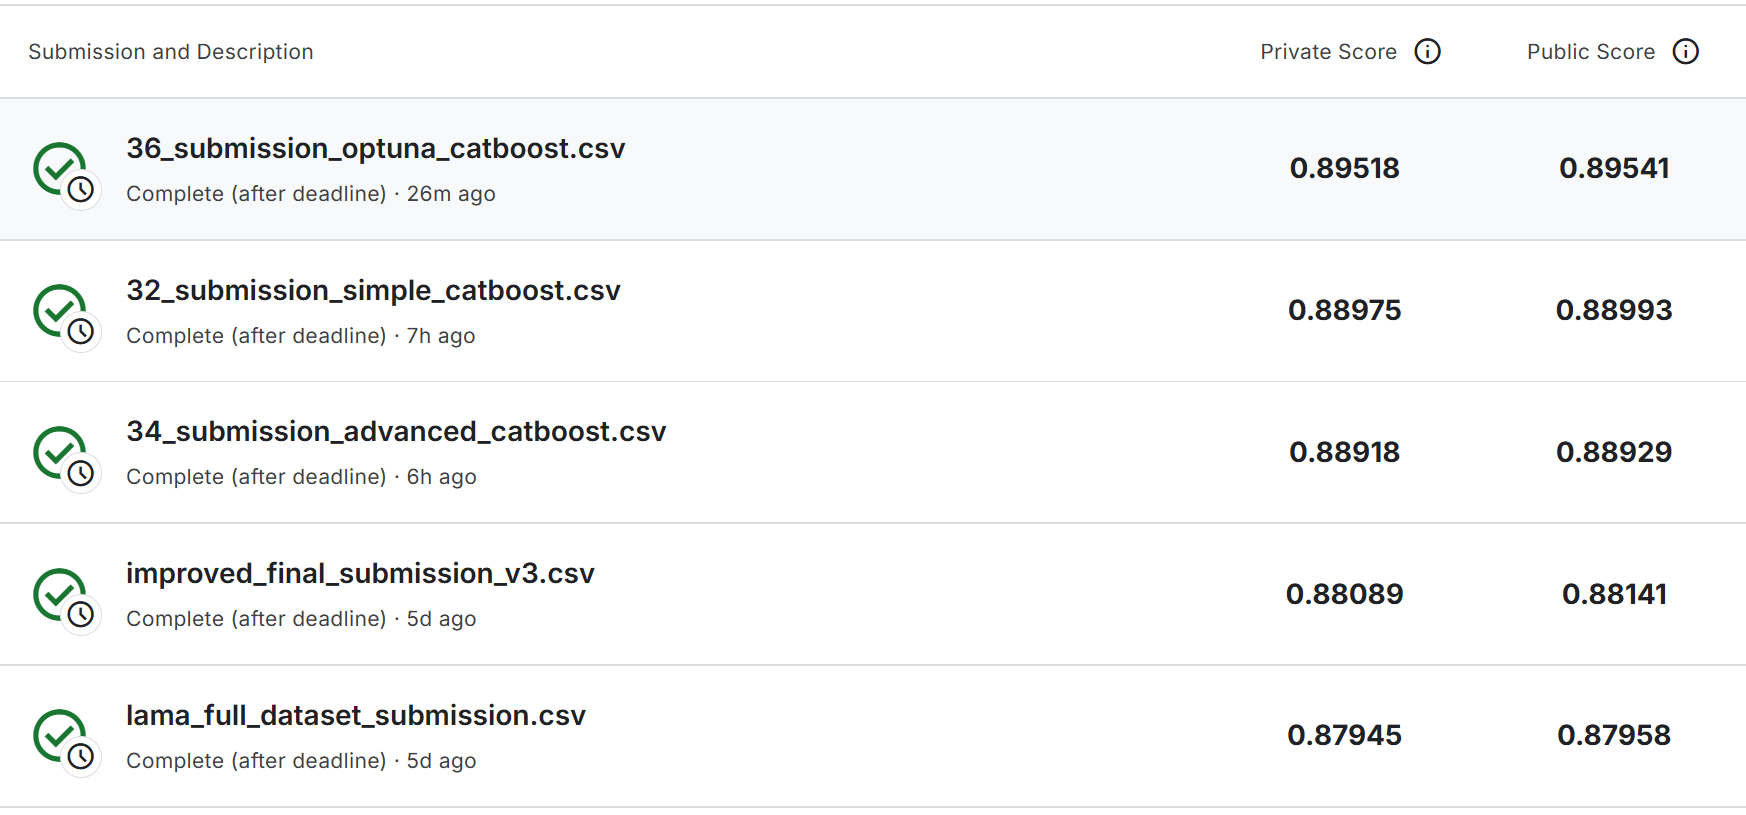

In [8]:
from IPython.display import Image, display
from pathlib import Path

image_path = Path('src/other/kaggle.png')

if image_path.exists():
    display(Image(image_path))
else:
    print(f"Изображение не найдено: {image_path}")

- Наилучший результат показал catboost с optuna `0.89518`
- LightGBM c optuna `0.88089`
- Бейзлайн на LightAutoML `0.87945`

### 7.2. Анализ позиции в рейтинге

Анализируем позицию лучших результатов относительно других участников соревнования

In [26]:
leaderboard = pd.read_csv('../playground-series-s4e7-publicleaderboard-2025-12-16T20_03_46.csv')
leaderboard_sorted = leaderboard.sort_values('Score', ascending=False).reset_index(drop=True)
total = len(leaderboard)

results = {
    'OptunaCatboost': 0.89541,
    'SimpleСatboost': 0.88993,
    'AdvancedCatboost': 0.88929,
    'LightGBM': 0.88141,
    'LightAutoML': 0.87958
}

analysis = []
for name, score in sorted(results.items(), key=lambda x: x[1], reverse=True):
    rank = leaderboard_sorted[leaderboard_sorted['Score'] <= score].index[0] + 1
    top_pct = len(leaderboard_sorted[leaderboard_sorted['Score'] > score]) / total * 100
    analysis.append({
        'Submission': name, 
        'Public Score': score, 
        'Rank': rank, 
        'Top %': round(top_pct, 2)
    })

results_df = pd.DataFrame(analysis)

best_score = leaderboard['Score'].max()
worst_score = leaderboard['Score'].min()
mean_score = leaderboard['Score'].mean()
median_score = leaderboard['Score'].median()

print(f"Всего участников: {total}\n")
print("Статистика лидерборда:")
print(f"Лучший результат: {best_score:.6f}")
print(f"Медианный результат: {median_score:.6f}")
print(f"Средний результат: {mean_score:.6f}")
print("\nПозиции в рейтинге:\n")
print(results_df.to_string(index=False))

Всего участников: 2236

Статистика лидерборда:
Лучший результат: 0.897930
Медианный результат: 0.876265
Средний результат: 0.806191

Позиции в рейтинге:

      Submission  Public Score  Rank  Top %
  OptunaCatboost       0.89541   339  15.12
  SimpleСatboost       0.88993   507  22.63
AdvancedCatboost       0.88929   520  23.21
        LightGBM       0.88141   719  32.11
     LightAutoML       0.87958   925  41.32


## 8. Выводы и заключение

### Основные результаты:

1. **EDA анализ** показал дисбаланс классов и важность некоторых признаков для предсказания целевой переменной

2. **LightAutoML baseline** показал хорошие результаты с двумя разными конфигурациями. Это подтверждает что автоматизированные подходы работают хорошо

3. **Собственное решение** с CatBoost дало значительное улучшение результатов по сравнению с baseline. Простой подход с минимальной предобработкой оказался самым эффективным

4. **Feature engineering** не дал значительного улучшения качества модели. Это значит что базовых признаков достаточно для этой задачи

5. **Оптимизация гиперпараметров** через Optuna помогла дополнительно улучшить качество модели

### Ключевые выводы:

* CatBoost показал лучшие результаты потому что хорошо работает с категориальными признаками
* Минимальная предобработка данных оказалась эффективнее чем сложные преобразования
* Оптимизация гиперпараметров важна для достижения максимального качества
* Простые подходы могут быть эффективнее чем сложные feature engineering техники

### Дополнительные исследования:

Во время исследования были проведены дополнительные эксперименты которые не показаны в этом блокноте:

* Разные варианты ансамблей моделей: stacking, blending
* Другие методы очистки данных и обработки аномалий
* Эксперименты с другими алгоритмами градиентного бустинга

Эти исследования подтвердили что простой CatBoost подход с оптимизацией гиперпараметров это лучшее решение для этой задачи.